## End-to-End Pipeline: Big Data with Knowledge Graph (Book-Referenced)

### Goal:
Transform news articles about technology company acquisitions into a structured Knowledge Graph, using modern techniques for extraction, refinement, and reasoning — guided by foundational principles outlined in a conceptual book.

### Dataset: CNN/DailyMail

### Approach Overview:
This notebook walks through a multi-phase process:
1.  **Data Acquisition & Preparation:** Sourcing and cleaning raw news text.
2.  **Information Extraction:** Identifying key entities (organizations, people, money, dates) and the relationships between them (e.g., 'acquire', 'invested_in').
3.  **Knowledge Graph Construction:** Structuring the extracted information into RDF triples, forming the nodes and edges of our KG.
4.  **KG Refinement (Conceptual):** Using embeddings to represent KG components and conceptually exploring link prediction.
5.  **Persistence & Utilization:** Storing, querying (SPARQL), and visualizing the KG.

We will leverage Large Language Models (LLMs) for complex NLP tasks like nuanced entity and relationship extraction, while also using traditional libraries like spaCy for initial exploration and `rdflib` for KG management.

# Table of Contents

- [End-to-End Pipeline: Big Data with Knowledge Graph (Book-Referenced)](#intro-0)
  - [Initial Setup: Imports and Configuration](#intro-setup)
    - [Initialize LLM Client and spaCy Model](#llm-spacy-init-desc)
    - [Define RDF Namespaces](#namespace-init-desc)
- [Phase 1: Data Acquisition and Preparation](#phase1)
  - [Step 1.1: Data Acquisition](#step1-1-desc)
    - [Execute Data Acquisition](#data-acquisition-exec-desc)
  - [Step 1.2: Data Cleaning & Preprocessing](#step1-2-desc)
    - [Execute Data Cleaning](#data-cleaning-exec-desc)
- [Phase 2: Information Extraction](#phase2)
  - [Step 2.1: Entity Extraction (Named Entity Recognition - NER)](#step2-1-desc)
    - [2.1.1: Entity Exploration with spaCy - Function Definition](#step2-1-1-spacy-desc)
    - [2.1.1: Entity Exploration with spaCy - Plotting Function Definition](#plot_entity_distribution_func_def_desc)
    - [2.1.1: Entity Exploration with spaCy - Execution](#spacy-ner-exec-desc)
    - [Generic LLM Call Function Definition](#llm-call-func-def-desc)
    - [2.1.2: Entity Type Selection using LLM - Execution](#step2-1-2-llm-type-selection-desc)
    - [LLM JSON Output Parsing Function Definition](#parse_llm_json_func_def_desc)
    - [2.1.3: Targeted Entity Extraction using LLM - Execution](#step2-1-3-llm-ner-exec-desc)
  - [Step 2.2: Relationship Extraction](#step2-2-desc)
- [Phase 3: Knowledge Graph Construction](#phase3)
  - [Step 3.1: Entity Disambiguation & Linking (Simplified) - Normalization Function](#step3-1-normalize-entity-text-func-def-desc)
    - [Execute Entity Normalization and URI Generation](#entity-normalization-exec-desc)
  - [Step 3.2: Schema/Ontology Alignment - RDF Type Mapping Function](#step3-2-rdf-type-func-def-desc)
    - [Schema/Ontology Alignment - RDF Predicate Mapping Function](#step3-2-rdf-predicate-func-def-desc)
    - [Schema/Ontology Alignment - Examples](#schema-alignment-example-desc)
  - [Step 3.3: Triple Generation](#step3-3-triple-generation-exec-desc)
- [Phase 4: Knowledge Graph Refinement Using Embeddings](#phase4)
  - [Step 4.1: Generate KG Embeddings - Embedding Function Definition](#step4-1-embedding-func-def-desc)
    - [Generate KG Embeddings - Execution](#kg-embedding-exec-desc)
  - [Step 4.2: Link Prediction (Knowledge Discovery - Conceptual) - Cosine Similarity Function](#step4-2-cosine-sim-func-def-desc)
    - [Link Prediction (Conceptual) - Similarity Calculation Example](#link-prediction-exec-desc)
  - [Step 4.3: Add Predicted Links (Optional & Conceptual) - Function Definition](#step4-3-add-inferred-func-def-desc)
    - [Add Predicted Links (Conceptual) - Execution Example](#add-predicted-links-exec-desc)
- [Phase 5: Persistence and Utilization](#phase5)
  - [Step 5.1: Knowledge Graph Storage - Save Function Definition](#step5-1-save-graph-func-def-desc)
    - [Knowledge Graph Storage - Execution](#kg-storage-exec-desc)
  - [Step 5.2: Querying and Analysis - SPARQL Execution Function](#step5-2-sparql-func-def-desc)
    - [SPARQL Querying and Analysis - Execution Examples](#sparql-querying-exec-desc)
  - [Step 5.3: Visualization (Optional) - Visualization Function Definition](#step5-3-viz-func-def-desc)
    - [KG Visualization - Execution](#visualization-exec-desc)
- [Conclusion and Future Work](#conclusion)

### Initial Setup: Imports and Configuration

**Theory:**
Before any data processing or analysis can begin, we need to set up our environment. This involves:
*   **Importing Libraries:** Bringing in the necessary Python packages. These include `datasets` for data loading, `openai` for interacting with LLMs, `spacy` for foundational NLP, `rdflib` for Knowledge Graph manipulation, `re` for text processing with regular expressions, `json` for handling LLM outputs, `matplotlib` and `pyvis` for visualization, and standard libraries like `os`, `collections`, and `tqdm`.
*   **API Configuration:** Setting up credentials and endpoints for external services, specifically the Nebius LLM API. **Security Note:** In a production environment, API keys should never be hardcoded. Use environment variables or secure secret management systems.
*   **Model Initialization:** Loading pre-trained models like spaCy's `en_core_web_sm` for basic NLP tasks and configuring the LLM client to use specific models deployed on Nebius for generation and embeddings.
*   **Namespace Definitions:** For RDF-based Knowledge Graphs, namespaces (like `EX` for our custom terms, `SCHEMA` for schema.org) are crucial for creating unique and resolvable URIs for entities and properties. This aligns with the Linked Data principles.

In [1]:
import os
import re
import json
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import time

# NLP and KG libraries
import spacy
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import RDF, RDFS, XSD, SKOS

# Google client for LLM & embeddings
import google.generativeai as genai

# Visualization
from pyvis.network import Network

# Hugging Face datasets library
from datasets import load_dataset

# For embedding similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# --- API Configuration (Google Gemini) ---
# Ensure your GOOGLE_API_KEY is set as an environment variable or
# replace the value below with your actual API key.
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY", "your_google_api_key_here")
genai.configure(api_key=GOOGLE_API_KEY)

# --- Model Names (replace with your actual Gemini model IDs) ---
TEXT_GEN_MODEL_NAME = "gemini-1.5-flash"
EMBEDDING_MODEL_NAME = "models/text-embedding-004"

print("Libraries imported and Google Gemini client initialized.")

Libraries imported and Google Gemini client initialized.


**Output Explanation:**
This block simply confirms that the necessary libraries have been imported without error.

#### Initialize LLM Client and spaCy Model

**Theory:**
Here, we instantiate the clients for our primary NLP tools:
*   **OpenAI Client:** Configured to point to the Nebius API. This client will be used to send requests to the deployed LLM for tasks like entity extraction, relation extraction, and generating embeddings. A basic check is performed to see if the configuration parameters are set.
*   **spaCy Model:** We load `en_core_web_sm`, a small English model from spaCy. This model provides efficient capabilities for tokenization, part-of-speech tagging, lemmatization, and basic Named Entity Recognition (NER). It's useful for initial text exploration and can complement LLM-based approaches.

In [2]:
import os
import spacy
import spacy.cli
import google.generativeai as genai

# --- API Configuration (Google Gemini) ---
# Ensure your GOOGLE_API_KEY is set as an environment variable or
# replace the value below with your actual API key.
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY", "your_google_api_key_here")
TEXT_GEN_MODEL_NAME = "gemini-1.5-flash"

if GOOGLE_API_KEY != "your_google_api_key_here" and TEXT_GEN_MODEL_NAME != "YOUR_TEXT_GENERATION_MODEL_NAME":
    try:
        genai.configure(api_key=GOOGLE_API_KEY)
        # The client object is implicitly configured, no need for a separate 'client' variable.
        print(f"Google Gemini client initialized using model: {TEXT_GEN_MODEL_NAME}")
    except Exception as e:
        print(f"Error initializing Google Gemini client: {e}")
else:
    print("Warning: Google Gemini client not fully configured. LLM features will be disabled. Please set GOOGLE_API_KEY and TEXT_GEN_MODEL_NAME.")

# --- spaCy Model Loading ---
nlp_spacy = None
try:
    nlp_spacy = spacy.load("en_core_web_sm")
    print("spaCy model 'en_core_web_sm' loaded.")
except OSError:
    print("spaCy model 'en_core_web_sm' not found. Downloading... (This might take a moment)")
    try:
        spacy.cli.download("en_core_web_sm")
        nlp_spacy = spacy.load("en_core_web_sm")
        print("spaCy model 'en_core_web_sm' downloaded and loaded successfully.")
    except Exception as e:
        print(f"Failed to download or load spaCy model: {e}")
        print("Please try: python -m spacy download en_core_web_sm in your terminal and restart the kernel.")
        nlp_spacy = None

Google Gemini client initialized using model: gemini-1.5-flash
spaCy model 'en_core_web_sm' loaded.


In [3]:
import os
import spacy
import spacy.cli
import google.generativeai as genai

# --- API Configuration (Google Gemini) ---
# Set your API key in your environment or replace the placeholder.
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY", "your_google_api_key_here")

if GOOGLE_API_KEY and GOOGLE_API_KEY != "your_google_api_key_here":
    try:
        genai.configure(api_key=GOOGLE_API_KEY)
        print("Google Gemini client initialized successfully.")
    except Exception as e:
        print(f"Error initializing Google Gemini client: {e}")
else:
    print("Google Gemini client not configured. Please set GOOGLE_API_KEY in your environment.")

# --- spaCy Model Setup ---
nlp_spacy = None
try:
    nlp_spacy = spacy.load("en_core_web_sm")
    print("spaCy model 'en_core_web_sm' loaded successfully.")
except OSError:
    print("🔄 spaCy model 'en_core_web_sm' not found. Downloading...")
    try:
        spacy.cli.download("en_core_web_sm")
        nlp_spacy = spacy.load("en_core_web_sm")
        print("spaCy model 'en_core_web_sm' downloaded and loaded.")
    except Exception as e:
        print(f"Failed to download or load spaCy model: {e}")
        print("Please run: python -m spacy download en_core_web_sm and restart your environment.")
        nlp_spacy = None

Google Gemini client initialized successfully.
spaCy model 'en_core_web_sm' loaded successfully.


**Output Explanation:**
This block prints messages indicating the status of the OpenAI client and spaCy model initialization. Warnings are shown if configurations are missing or models can't be loaded.

#### Define RDF Namespaces

**Theory:**
In RDF, namespaces are used to avoid naming conflicts and to provide context for terms (URIs). 
*   `EX`: A custom namespace for terms specific to our project (e.g., our entities and relationships if not mapped to standard ontologies).
*   `SCHEMA`: Refers to Schema.org, a widely used vocabulary for structured data on the internet. We'll try to map some of our extracted types to Schema.org terms for better interoperability.
*   `RDFS`: RDF Schema, provides basic vocabulary for describing RDF vocabularies (e.g., `rdfs:label`, `rdfs:Class`).
*   `RDF`: The core RDF vocabulary (e.g., `rdf:type`).
*   `XSD`: XML Schema Datatypes, used for specifying literal data types (e.g., `xsd:string`, `xsd:date`).
*   `SKOS`: Simple Knowledge Organization System, useful for thesauri, taxonomies, and controlled vocabularies (e.g., `skos:altLabel` for alternative names).

In [4]:
from rdflib import Namespace

EX = Namespace("http://example.org/kg/")
SCHEMA = Namespace("http://schema.org/")

print(f"Custom namespace EX defined as: {EX}")
print(f"Schema.org namespace SCHEMA defined as: {SCHEMA}")

Custom namespace EX defined as: http://example.org/kg/
Schema.org namespace SCHEMA defined as: http://schema.org/


**Output Explanation:**
This confirms the definition of our primary custom namespace (`EX`) and the `SCHEMA` namespace from Schema.org.

## Phase 1: Data Acquisition and Preparation
**(Ref: Ch. 1 – Big Data Ecosystem; Ch. 3 – Value Chain of Big Data Processing)**

**Theory (Phase Overview):**
This initial phase is critical in any data-driven project. It corresponds to the early stages of the Big Data value chain: "Data Acquisition" and parts of "Data Preparation/Preprocessing". The goal is to obtain the raw data and transform it into a state suitable for further processing and information extraction. Poor quality input data (the "Garbage In, Garbage Out" principle) will inevitably lead to a poor quality Knowledge Graph.

### Step 1.1: Data Acquisition
**Task:** Gather a collection of news articles.

**Book Concept:** (Ch. 1, Figures 1 & 2; Ch. 3 - Data Acquisition stage)
This step represents the "Data Sources" and "Ingestion" components of a Big Data ecosystem. We're tapping into an existing dataset (CNN/DailyMail via Hugging Face `datasets`) rather than scraping live news, but the principle is the same: bringing external data into our processing pipeline.

**Methodology:**
We will define a function `acquire_articles` to load the CNN/DailyMail dataset. To manage processing time and costs for this demonstration, and to focus on potentially relevant articles, this function will:
1.  Load a specified split (e.g., 'train') of the dataset.
2.  Optionally filter articles based on a list of keywords. For our goal of technology company acquisitions, keywords like "acquire", "merger", "technology", "startup" would be relevant. This is a simple heuristic; more advanced topic modeling or classification could be used for better filtering on larger datasets.
3.  Take a small sample of the (filtered) articles.

**Output:** A list of raw article data structures (typically dictionaries containing 'id', 'article' text, etc.).

In [5]:
def acquire_articles(dataset_name="cnn_dailymail", version="3.0.0", split='train', sample_size=1000, keyword_filter=None):
    """Loads articles from the specified Hugging Face dataset, optionally filters them, and takes a sample."""
    print(f"Attempting to load dataset: {dataset_name} (version: {version}, split: '{split}')...")
    try:
        full_dataset = load_dataset(dataset_name, version, split=split, streaming=False) # Use streaming=False for easier slicing on smaller datasets
        print(f"Successfully loaded dataset. Total records in split: {len(full_dataset)}")
    except Exception as e:
        print(f"Error loading dataset {dataset_name}: {e}")
        print("Please ensure the dataset is available or you have internet connectivity.")
        return [] # Return empty list on failure
    
    raw_articles_list = []
    if keyword_filter:
        print(f"Filtering articles containing any of keywords: {keyword_filter}...")
        # This is a simple keyword search. For very large datasets, this can be slow.
        # Consider .filter() method of Hugging Face datasets for more efficiency if not streaming.
        count = 0
        # To avoid iterating the whole dataset if it's huge and we only need a small sample after filtering:
        # We'll iterate up to a certain point or until we have enough filtered articles.
        # This is a heuristic for balancing filtering with performance on potentially large datasets.
        iteration_limit = min(len(full_dataset), sample_size * 20) # Look through at most 20x sample_size articles
        for i in tqdm(range(iteration_limit), desc="Filtering articles"):
            record = full_dataset[i]
            if any(keyword.lower() in record['article'].lower() for keyword in keyword_filter):
                raw_articles_list.append(record)
                count += 1
            if count >= sample_size:
                print(f"Found {sample_size} articles matching filter criteria within {i+1} records checked.")
                break
        if not raw_articles_list:
            print(f"Warning: No articles found with keywords {keyword_filter} within the first {iteration_limit} records. Returning an empty list.")
            return []
        # If we found articles but less than sample_size, we take what we found.
        # If we found more, we still only take sample_size.
        raw_articles_list = raw_articles_list[:sample_size]
    else:
        print(f"Taking the first {sample_size} articles without keyword filtering.")
        # Ensure sample_size does not exceed dataset length
        actual_sample_size = min(sample_size, len(full_dataset))
        raw_articles_list = list(full_dataset.select(range(actual_sample_size)))
        
    print(f"Acquired {len(raw_articles_list)} articles.")
    return raw_articles_list

print("Function 'acquire_articles' defined.")

Function 'acquire_articles' defined.


In [9]:
import os
import re
import json
import pickle  # <-- Add this for saving/loading vector stores
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import time

# NLP and KG libraries
import spacy
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import RDF, RDFS, XSD, SKOS

# Google client for LLM & embeddings
import google.generativeai as genai

# Visualization
from pyvis.network import Network

# Hugging Face datasets library
from datasets import load_dataset

# For embedding similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from PyPDF2 import PdfReader


In [10]:
import os
import re
import json
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import time

# NLP and KG libraries
import spacy
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import RDF, RDFS, XSD, SKOS

# Google client for LLM & embeddings
import google.generativeai as genai

# Visualization
from pyvis.network import Network

# Hugging Face datasets library
from datasets import load_dataset

# For embedding similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from PyPDF2 import PdfReader

# --- API Configuration (Google Gemini) ---
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY", "your_google_api_key_here")
genai.configure(api_key=GOOGLE_API_KEY)
TEXT_GEN_MODEL_NAME = "gemini-1.5-flash"
EMBEDDING_MODEL_NAME = "models/embedding-001"

# --- Define all necessary functions ---

def acquire_articles(dataset_name="cnn_dailymail", version="3.0.0", split='train', sample_size=1000, keyword_filter=None):
    """Loads articles from the specified Hugging Face dataset, optionally filters them, and takes a sample."""
    print(f"Attempting to load dataset: {dataset_name} (version: {version}, split: '{split}')...")
    try:
        full_dataset = load_dataset(dataset_name, version, split=split, streaming=False)
        print(f"Successfully loaded dataset. Total records in split: {len(full_dataset)}")
    except Exception as e:
        print(f"Error loading dataset {dataset_name}: {e}")
        return []
    
    raw_articles_list = []
    if keyword_filter:
        print(f"Filtering articles containing any of keywords: {keyword_filter}...")
        count = 0
        iteration_limit = min(len(full_dataset), sample_size * 20)
        for i in tqdm(range(iteration_limit), desc="Filtering articles"):
            record = full_dataset[i]
            if any(keyword.lower() in record['article'].lower() for keyword in keyword_filter):
                raw_articles_list.append(record)
                count += 1
            if count >= sample_size:
                print(f"Found {sample_size} articles matching filter criteria within {i+1} records checked.")
                break
        if not raw_articles_list:
            print(f"Warning: No articles found with keywords {keyword_filter} within the first {iteration_limit} records. Returning an empty list.")
            return []
        raw_articles_list = raw_articles_list[:sample_size]
    else:
        print(f"Taking the first {sample_size} articles without keyword filtering.")
        actual_sample_size = min(sample_size, len(full_dataset))
        raw_articles_list = list(full_dataset.select(range(actual_sample_size)))
        
    print(f"Acquired {len(raw_articles_list)} articles.")
    return raw_articles_list

class SimpleVectorStore:
    def __init__(self) -> None:
        self.embeddings: List[np.ndarray] = []
        self.documents: List[Dict[str, Any]] = []
    
    def add_item(self, *, text: str, embedding: Union[np.ndarray, List[float]], metadata: Optional[Dict[str, Any]] = None) -> None:
        doc = {"text": text, "metadata": (metadata or {})}
        self._add_core(embedding, doc)

    def add(self, embedding: Union[np.ndarray, List[float]], document: Union[Dict[str, Any], str]) -> None:
        if isinstance(document, str):
            doc = {"text": document, "metadata": {}}
        else:
            doc = {"text": document.get("text", ""), "metadata": document.get("metadata", {})}
        self._add_core(embedding, doc)

    def similarity_search(self, query_embedding: Union[np.ndarray, List[float]], k: int = 5, filter_func: Optional[Callable[[Dict[str, Any]], bool]] = None, return_scores: bool = False):
        if not self.embeddings:
            return []
        
        q = self._as_unit_vector(query_embedding)
        sims: List[Tuple[int, float]] = []
        for i, emb in enumerate(self.embeddings):
            doc = self.documents[i]
            if filter_func is not None and not filter_func(doc):
                continue
            sim = float(np.dot(q, emb))
            sims.append((i, sim))

        if not sims:
            return []
        
        sims.sort(key=lambda t: t[1], reverse=True)
        top = sims[:max(0, int(k))]
        
        if return_scores:
            return [(self.documents[i], score) for i, score in top]
        else:
            return [self.documents[i] for i, _ in top]
    
    def save(self, path: str) -> None:
        with open(path, "wb") as f:
            pickle.dump({"embeddings": self.embeddings, "documents": self.documents}, f)

    @classmethod
    def load(cls, path: str) -> "SimpleVectorStore":
        with open(path, "rb") as f:
            data = pickle.load(f)
        store = cls()
        store.embeddings = [np.asarray(e, dtype=float).reshape(-1) for e in data.get("embeddings", [])]
        store.documents = data.get("documents", [])
        store.embeddings = [store._as_unit_vector(e) for e in store.embeddings]
        return store

    def _add_core(self, embedding: Union[np.ndarray, List[float]], doc: Dict[str, Any]) -> None:
        emb = self._as_unit_vector(embedding)
        self.embeddings.append(emb)
        self.documents.append(doc)

    def _as_unit_vector(self, x: Union[np.ndarray, List[float]]) -> np.ndarray:
        v = np.asarray(x, dtype=float).reshape(-1)
        n = np.linalg.norm(v)
        if n == 0:
            return v
        return v / n

def _safe_get_page(doc: Dict[str, Any]):
    meta = doc.get("metadata") or {}
    for k in ("page", "page_num", "page_number", "pg"):
        if k in meta:
            return meta[k]
    return None

def extract_text_pages(pdf_path: str) -> List[str]:
    pages = []
    try:
        with open(pdf_path, "rb") as f:
            reader = PdfReader(f)
            for p in reader.pages:
                pages.append(p.extract_text() or "")
    except FileNotFoundError:
        print(f"Error: The file at {pdf_path} was not found.")
        return []
    return pages

def chunk_text(text: str, chunk_size=1000, overlap=200) -> List[Tuple[str, int]]:
    chunks = []
    start = 0
    n = len(text)
    while start < n:
        end = min(n, start + chunk_size)
        chunks.append((text[start:end], start))
        if end == n: break
        start = max(end - overlap, start + 1)
    return chunks

def create_embeddings(texts: Union[str, List[str]], model="models/embedding-001", max_retries=3, sleep_sec=1.5):
    if not texts:
        return [] if isinstance(texts, list) else None

    input_texts = texts if isinstance(texts, list) else [texts]
    vectors = []
    for t in input_texts:
        if t is None:
            vectors.append([])
            continue
        text = str(t)
        
        last_err = None
        for attempt in range(1, max_retries + 1):
            try:
                resp = genai.embed_content(model=model, content=text)
                if isinstance(resp, dict):
                    emb = resp.get("embedding", {})
                    values = emb.get("values", [])
                else:
                    values = getattr(getattr(resp, "embedding", None), "values", [])
                vectors.append(list(values))
                break
            except Exception as e:
                last_err = e
                if attempt < max_retries:
                    time.sleep(sleep_sec * attempt)
                else:
                    vectors.append([])
        if last_err and vectors[-1] == []:
            pass

    return vectors if isinstance(texts, list) else vectors[0]

def generate_page_summary(page_text: str) -> str:
    system_prompt = "You are an AI assistant. Summarize the following text in a concise paragraph."
    max_chars = 3000
    truncated_text = page_text[:max_chars] if len(page_text) > max_chars else page_text
    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(
        f"{system_prompt}\n\n{truncated_text}",
        generation_config={"temperature": 0.3}
    )
    return response.text.strip()

def process_document_hierarchically(pdf_path: str, chunk_size=1000, chunk_overlap=200):
    pages = extract_text_pages(pdf_path)
    if not pages:
        return SimpleVectorStore(), SimpleVectorStore()
    
    detailed_store = SimpleVectorStore()
    detailed_text_items = []
    for page_idx, page_text in enumerate(pages):
        page_text = page_text.strip()
        if not page_text:
            continue
        detailed_text_items.append((page_idx, page_text))
        for chunk_text_str, start_idx in chunk_text(page_text, chunk_size, chunk_overlap):
            emb = create_embeddings(chunk_text_str)
            if emb:
                detailed_store.add_item(
                    text=chunk_text_str,
                    embedding=emb,
                    metadata={"page": page_idx, "char_start": start_idx}
                )

    summary_store = SimpleVectorStore()
    for page_idx, full_text in detailed_text_items:
        summary_text = full_text[:350] if len(full_text) > 350 else full_text
        emb = create_embeddings(summary_text)
        if emb:
            summary_store.add_item(
                text=summary_text,
                embedding=emb,
                metadata={"page": page_idx}
            )
    return summary_store, detailed_store

def retrieve_hierarchically(query: str, summary_store: SimpleVectorStore, detailed_store: SimpleVectorStore, k_summaries=5, k_chunks=10):
    query_emb = create_embeddings(query)
    if not query_emb:
        return []
    
    summary_docs = summary_store.similarity_search(query_emb, k=k_summaries, return_scores=False)
    relevant_pages = {p for p in (_safe_get_page(d) for d in summary_docs) if p is not None and p != -1}

    if not relevant_pages:
        return detailed_store.similarity_search(query_emb, k=max(1, k_chunks), return_scores=False)

    def page_filter(doc):
        return _safe_get_page(doc) in relevant_pages

    detailed_docs = detailed_store.similarity_search(
        query_emb,
        k=max(1, k_chunks * max(1, len(relevant_pages))),
        filter_func=page_filter,
        return_scores=False
    )
    return detailed_docs

def generate_response(query: str, retrieved_docs: List[Dict[str, Any]], max_chars=1200):
    context = ""
    for d in retrieved_docs:
        t = d.get("text", "")
        if not t: continue
        space_left = max_chars - len(context)
        if space_left <= 0: break
        context += (t[:space_left] + "\n")
    answer = f"Based on the document, key points include:\n{context.strip()}"
    return answer

def hierarchical_rag(query, pdf_path, chunk_size=1000, chunk_overlap=200, k_summaries=5, k_chunks=10, regenerate=False):
    base = os.path.splitext(os.path.basename(pdf_path))[0]
    summary_pkl = f"{base}__summary_store.pkl"
    detailed_pkl = f"{base}__detailed_store.pkl"

    if regenerate or not (os.path.exists(summary_pkl) and os.path.exists(detailed_pkl)):
        print("Processing document and creating vector stores...")
        summary_store, detailed_store = process_document_hierarchically(pdf_path, chunk_size, chunk_overlap)
        with open(summary_pkl, "wb") as f: pickle.dump(summary_store, f)
        with open(detailed_pkl, "wb") as f: pickle.dump(detailed_store, f)
    else:
        print("Loading existing vector stores...")
        with open(summary_pkl, "rb") as f: summary_store = pickle.load(f)
        with open(detailed_pkl, "rb") as f: detailed_store = pickle.load(f)

    retrieved = retrieve_hierarchically(query, summary_store, detailed_store, k_summaries, k_chunks)
    response = generate_response(query, retrieved)

    return {"response": response, "chunks_used": retrieved}

def standard_rag(query: str, pdf_path: str, k=15):
    base = os.path.splitext(os.path.basename(pdf_path))[0]
    detailed_pkl = f"{base}__detailed_store.pkl"
    if not os.path.exists(detailed_pkl):
        _ = hierarchical_rag("warmup", pdf_path, regenerate=True)
    with open(detailed_pkl, "rb") as f:
        detailed_store = pickle.load(f)

    query_emb = create_embeddings(query)
    docs = detailed_store.similarity_search(query_emb, k=k, return_scores=False)
    return {"response": generate_response(query, docs), "chunks_used": docs}

def _cosine(a, b):
    a = np.asarray(a, dtype=float).reshape(-1)
    b = np.asarray(b, dtype=float).reshape(-1)
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0: return 0.0
    return float(np.dot(a, b) / (na * nb))

def run_evaluation(pdf_path: str, test_queries: List[str], reference_answers: List[str]):
    results = []
    for q in test_queries:
        hier = hierarchical_rag(q, pdf_path)
        base = standard_rag(q, pdf_path)

        hier_emb = create_embeddings(hier["response"])
        base_emb = create_embeddings(base["response"])

        ref_scores_h = []
        ref_scores_b = []
        for ref in reference_answers:
            ref_emb = create_embeddings(ref)
            ref_scores_h.append(_cosine(hier_emb, ref_emb))
            ref_scores_b.append(_cosine(base_emb, ref_emb))

        results.append({
            "query": q,
            "hierarchical_score": max(ref_scores_h) if ref_scores_h else 0.0,
            "standard_score": max(ref_scores_b) if ref_scores_b else 0.0,
            "hierarchical_response": hier["response"],
            "standard_response": base["response"],
        })

    avg_h = sum(r["hierarchical_score"] for r in results) / max(1, len(results))
    avg_b = sum(r["standard_score"] for r in results) / max(1, len(results))
    verdict = "Hierarchical > Standard" if avg_h > avg_b else ("Standard > Hierarchical" if avg_b > avg_h else "Tie")

    return {
        "per_query": results,
        "overall": {"avg_hierarchical": avg_h, "avg_standard": avg_b, "verdict": verdict},
        "overall_analysis": f"Avg(Hierarchical)={avg_h:.3f}, Avg(Standard)={avg_b:.3f} → {verdict}"
    }

# --- Main Execution Block ---

# Path to the AI information PDF document
pdf_path = "/Users/kekunkoya/Desktop/ISEM 770 Class Project/Homelessness.pdf"

# Example query about AI for testing the hierarchical RAG approach
query = "What have been done to prevent homelessness?"
print(f"Running Hierarchical RAG for query: {query}")
result = hierarchical_rag(query, pdf_path)

print("\n=== Response ===")
print(result["response"])

# Test query for formal evaluation (using only one query as requested)
test_queries = [
     "What are the strategies to prevent homelessness?"
]

# Reference answer for the test query to enable comparison
reference_answers = [
    "Prevent new incidences of homelessness through early intervention and support services.",  
    "Address and mitigate the underlying causes of homelessness, such as poverty, unemployment, and lack of affordable housing.", 
    "Reduce the overall number of people experiencing homelessness via rapid rehousing and housing-first models.", 
    "Minimize the negative social, health, and economic impacts on individuals and families currently experiencing homelessness.", 
    "Ensure formerly homeless people maintain permanent, independent housing through ongoing support and follow-up services."
]

print("\n\n" + "="*20 + " Running Evaluation " + "="*20 + "\n")
# Run the evaluation comparing hierarchical and standard RAG approaches
evaluation_results = run_evaluation(
    pdf_path=pdf_path,
    test_queries=test_queries,
    reference_answers=reference_answers
)

# Print the overall analysis of the comparison
print("\n=== OVERALL ANALYSIS ===")
print(evaluation_results["overall_analysis"])

Running Hierarchical RAG for query: What have been done to prevent homelessness?
Loading existing vector stores...

=== Response ===
Based on the document, key points include:



==================== Running Evaluation ====================

Loading existing vector stores...

=== OVERALL ANALYSIS ===
Avg(Hierarchical)=0.000, Avg(Standard)=0.000 → Tie


**Output Explanation:**
This cell defines the `acquire_articles` function. It will print a confirmation once the function is defined in the Python interpreter's memory.

#### Execute Data Acquisition

**Theory:**
Now we call the `acquire_articles` function. We define keywords relevant to our goal (technology company acquisitions) to guide the filtering process. A `SAMPLE_SIZE` is set to keep the amount of data manageable for this demonstration. Smaller samples allow for faster iteration, especially when using LLMs which can have associated costs and latency.

In [11]:
# === Keywords from ETHOS typology & measurement concepts (from your Homelessness.pdf) ===
ETHOS_CORE = [
    "ETHOS", "rooflessness", "houselessness",
    "insecure housing", "inadequate housing",
    "rough sleeping", "night shelter", "homeless hostel",
    "temporary accommodation", "transitional supported accommodation",
    "women’s shelter", "womens shelter", "women's shelter",
    "accommodation for immigrants", "migrant workers’ accommodation",
    "penal institutions", "medical institutions", "children’s institutions",
    "supported accommodation", "supported housing"
]

RISK_THREATS = [
    "eviction", "repossession", "threat of violence", "domestic violence",
    "illegal occupation", "no security of tenure"
]

INADEQUATE_FORMS = [
    "mobile homes", "non-conventional building", "temporary structure",
    "unfit housing", "extreme overcrowding", "overcrowding"
]

MEASUREMENT_TERMS = [
    "point-in-time", "prevalence", "annual prevalence", "lifetime prevalence",
    "inflow", "outflow", "stock figure", "flow figure",
    "client register", "data collection", "indicators"
]

POLICY_STRATEGY = [
    "Housing First", "prevention of homelessness",
    "long-term homelessness", "chronic homelessness",
    "episodic homelessness", "transitional homelessness",
    "hidden homelessness"
]

# Combine into a single filter list (lowercased comparison happens in acquire step)
HOMELESSNESS_KEYWORDS = (
    ETHOS_CORE
    + RISK_THREATS
    + INADEQUATE_FORMS
    + MEASUREMENT_TERMS
    + POLICY_STRATEGY
)

# For this demo, filter by homelessness-related terms from the PDF
FILTER_KEYWORDS = HOMELESSNESS_KEYWORDS

# Keep sample size small so LLM steps later stay fast
SAMPLE_SIZE = 10

# Acquire a small sample set filtered by the ETHOS/measurement terms
raw_data_sample = acquire_articles(sample_size=SAMPLE_SIZE, keyword_filter=FILTER_KEYWORDS)

if raw_data_sample:
    print(f"\nExample of a raw acquired article (ID: {raw_data_sample[0]['id']}):")
    print(raw_data_sample[0]['article'][:500] + "...")
    print(f"\nNumber of fields in a record: {len(raw_data_sample[0].keys())}")
    print(f"Fields: {list(raw_data_sample[0].keys())}")
else:
    print("No articles were acquired with the ETHOS/measurement keyword filter. "
          "Consider increasing SAMPLE_SIZE, loosening FILTER_KEYWORDS, or using a different split.")


Attempting to load dataset: cnn_dailymail (version: 3.0.0, split: 'train')...
Successfully loaded dataset. Total records in split: 287113
Filtering articles containing any of keywords: ['ETHOS', 'rooflessness', 'houselessness', 'insecure housing', 'inadequate housing', 'rough sleeping', 'night shelter', 'homeless hostel', 'temporary accommodation', 'transitional supported accommodation', 'women’s shelter', 'womens shelter', "women's shelter", 'accommodation for immigrants', 'migrant workers’ accommodation', 'penal institutions', 'medical institutions', 'children’s institutions', 'supported accommodation', 'supported housing', 'eviction', 'repossession', 'threat of violence', 'domestic violence', 'illegal occupation', 'no security of tenure', 'mobile homes', 'non-conventional building', 'temporary structure', 'unfit housing', 'extreme overcrowding', 'overcrowding', 'point-in-time', 'prevalence', 'annual prevalence', 'lifetime prevalence', 'inflow', 'outflow', 'stock figure', 'flow figur

Filtering articles:   0%|          | 0/200 [00:00<?, ?it/s]

Acquired 2 articles.

Example of a raw acquired article (ID: 487b272b94a620f9660e89bbf6ebab3ffdf1bf06):
CARACAS, Venezuela (CNN)  -- The price of sin rose Monday in Venezuela where President Hugo Chavez is on a campaign to make Venezuelans cut back on drinking and smoking. "Everyone's shocked," said Leonora Marino, owner of Bodegon Marino in Valencia, Venezuela, west of Caracas. On Monday evening, she was still changing the prices in her store as her customers looked on and complained, she told a reporter. Alcohol is now 10 percent more expensive; cigarettes are 20 percent pricier. "Really, it's d...

Number of fields in a record: 3
Fields: ['article', 'highlights', 'id']


**Output Explanation:**
This block executes the data acquisition. It will print:
*   Messages about the data loading and filtering process.
*   The number of articles acquired.
*   A snippet of the first acquired article and its available fields, to verify the process and understand the data structure.

### Step 1.2: Data Cleaning & Preprocessing
**Task:** Perform basic text normalization.

**Book Concept:** (Ch. 3 - Variety challenge of Big Data)
Raw text data from sources like news articles is often messy. It can contain HTML tags, boilerplate content (like bylines, copyright notices), special characters, and inconsistent formatting. This step parallels addressing the "Variety" (and to some extent, "Veracity") challenge of Big Data. Clean, normalized input is crucial for effective downstream NLP tasks, as noise can significantly degrade the performance of entity recognizers and relation extractors.

**Methodology:**
We'll define a function `clean_article_text` that uses regular expressions (`re` module) to:
*   Remove common news boilerplate (e.g., "(CNN) --", specific byline patterns).
*   Remove HTML tags and URLs.
*   Normalize whitespace (e.g., replace multiple spaces/newlines with a single space).
*   Optionally, handle quotes or other special characters that might interfere with LLM processing or JSON formatting if not handled carefully.

**Output:** A list of dictionaries, where each dictionary contains the article ID and its cleaned text.

In [12]:
def clean_article_text(raw_text):
    """Cleans the raw text of a news article using regular expressions."""
    text = raw_text
    
    # Remove (CNN) style prefixes
    text = re.sub(r'^\(CNN\)\s*(--)?\s*', '', text)
    # Remove common bylines and publication/update lines (patterns may need adjustment for specific dataset nuances)
    text = re.sub(r'By .*? for Dailymail\.com.*?Published:.*?Updated:.*', '', text, flags=re.IGNORECASE | re.DOTALL)
    text = re.sub(r'PUBLISHED:.*?BST,.*?UPDATED:.*?BST,.*', '', text, flags=re.IGNORECASE | re.DOTALL)
    text = re.sub(r'Last updated at.*on.*', '', text, flags=re.IGNORECASE)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '[EMAIL]', text)
    # Normalize whitespace: replace newlines, tabs with a single space, then multiple spaces with a single space
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    text = re.sub(r'\s+', ' ', text).strip()
    # Optional: escape quotes if LLM has issues, but usually not needed for good models
    # text = text.replace('"', "\\\"").replace("'", "\\'") 
    return text

print("Function 'clean_article_text' defined.")

Function 'clean_article_text' defined.


**Output Explanation:**
Confirms that the `clean_article_text` function, which will be used to preprocess article content, has been defined.

#### Execute Data Cleaning

**Theory:**
This block iterates through the `raw_data_sample` (acquired in the previous step). For each article, it calls the `clean_article_text` function. The cleaned text, along with the original article ID and potentially other useful fields like 'summary' (if available from the dataset as 'highlights'), is stored in a new list called `cleaned_articles`. This new list will be the primary input for the subsequent Information Extraction phase.

In [13]:
cleaned_articles = [] # Initialize as an empty list

if raw_data_sample: # Proceed only if raw_data_sample is not empty
    print(f"Cleaning {len(raw_data_sample)} acquired articles...")
    for record in tqdm(raw_data_sample, desc="Cleaning articles"):
        cleaned_text_content = clean_article_text(record['article'])
        cleaned_articles.append({
            "id": record['id'],
            "original_text": record['article'], # Keep original for reference
            "cleaned_text": cleaned_text_content,
            "summary": record.get('highlights', '') # CNN/DM has 'highlights' which are summaries
        })
    print(f"Finished cleaning. Total cleaned articles: {len(cleaned_articles)}.")
    if cleaned_articles: # Check if list is not empty after processing
        print(f"\nExample of a cleaned article (ID: {cleaned_articles[0]['id']}):")
        print(cleaned_articles[0]['cleaned_text'][:500] + "...")
else:
    print("No raw articles were acquired in the previous step, so skipping cleaning.")

# This ensures cleaned_articles is always defined, even if empty.
if 'cleaned_articles' not in globals():
    cleaned_articles = []
    print("Initialized 'cleaned_articles' as an empty list because it was not created prior.")

Cleaning 2 acquired articles...


Cleaning articles:   0%|          | 0/2 [00:00<?, ?it/s]

Finished cleaning. Total cleaned articles: 2.

Example of a cleaned article (ID: 487b272b94a620f9660e89bbf6ebab3ffdf1bf06):
CARACAS, Venezuela (CNN) -- The price of sin rose Monday in Venezuela where President Hugo Chavez is on a campaign to make Venezuelans cut back on drinking and smoking. "Everyone's shocked," said Leonora Marino, owner of Bodegon Marino in Valencia, Venezuela, west of Caracas. On Monday evening, she was still changing the prices in her store as her customers looked on and complained, she told a reporter. Alcohol is now 10 percent more expensive; cigarettes are 20 percent pricier. "Really, it's di...


**Output Explanation:**
This block will:
*   Indicate the start and end of the cleaning process.
*   Show the number of articles cleaned.
*   Display a snippet of the first cleaned article's text, allowing for a visual check of the cleaning effectiveness.

## Phase 2: Information Extraction
**(Ref: Ch. 2 – Basics of Knowledge Graphs; Ch. 4 – KG Creation from Structured Data)**

**Theory (Phase Overview):**
Information Extraction (IE) is the process of automatically extracting structured information from unstructured or semi-structured sources (like our news articles). In the context of Knowledge Graph creation, IE is paramount as it identifies the fundamental building blocks: entities (nodes) and the relationships (edges) that connect them. This phase directly addresses how to transform raw text into a more structured format, a key step before KG materialization (Ch. 4). It involves tasks like Named Entity Recognition (NER) and Relationship Extraction (RE).

### Step 2.1: Entity Extraction (Named Entity Recognition - NER)
**Task:** Identify named entities like organizations, people, products, monetary figures, and dates.

**Book Concept:** (Ch. 2 - Entities as nodes)
Named Entities are real-world objects, such as persons, locations, organizations, products, etc., that can be denoted with a proper name. In a KG, these entities become the *nodes*. Accurate NER is foundational for building a meaningful graph.

**Methodology:**
We'll employ a two-pronged approach:
1.  **Exploratory NER with spaCy:** Use spaCy's pre-trained model to get a quick overview of common entity types present in our cleaned articles. This helps in understanding the general landscape of entities.
2.  **LLM-driven Entity Type Selection:** Based on spaCy's output and our specific goal (technology acquisitions), we'll prompt an LLM to suggest a focused set of entity types that are most relevant.
3.  **Targeted NER with LLM:** Use the LLM with the refined list of entity types to perform NER on the articles, aiming for higher accuracy and relevance for our specific domain. LLMs can be powerful here due to their contextual understanding, especially when guided by well-crafted prompts.

#### 2.1.1: Entity Exploration with spaCy - Function Definition

**Theory:**
This function, `get_spacy_entity_counts`, takes a list of articles, processes a sample of their text using spaCy's NER capabilities, and returns a counter object tallying the frequencies of different entity labels (e.g., `PERSON`, `ORG`, `GPE`). This gives us an empirical basis for understanding what kinds of entities are prevalent in our dataset before we engage the more resource-intensive LLM.

In [14]:
def get_spacy_entity_counts(articles_data, text_field='cleaned_text', sample_size_spacy=50):
    """Processes a sample of articles with spaCy and counts entity labels."""
    if not nlp_spacy:
        print("spaCy model not loaded. Skipping spaCy entity counting.")
        return Counter()
    if not articles_data:
        print("No articles data provided to spaCy for entity counting. Skipping.")
        return Counter()
    
    label_counter = Counter()
    # Process a smaller sample for quick spaCy analysis
    sample_to_process = articles_data[:min(len(articles_data), sample_size_spacy)]
    
    print(f"Processing {len(sample_to_process)} articles with spaCy for entity counts...")
    for article in tqdm(sample_to_process, desc="spaCy NER for counts"):
        doc = nlp_spacy(article[text_field])
        for ent in doc.ents:
            label_counter[ent.label_] += 1
    return label_counter

print("Function 'get_spacy_entity_counts' defined.")

Function 'get_spacy_entity_counts' defined.


**Output Explanation:**
Confirms the definition of the `get_spacy_entity_counts` function.

#### 2.1.1: Entity Exploration with spaCy - Plotting Function Definition

**Theory:**
The `plot_entity_distribution` function takes the entity counts (from `get_spacy_entity_counts`) and uses `matplotlib` to generate a bar chart. Visualizing this distribution helps in quickly identifying the most frequent entity types, which can inform subsequent decisions about which types to prioritize for the KG.

In [15]:
def plot_entity_distribution(label_counter_to_plot):
    """Plots the distribution of entity labels from a Counter object."""
    if not label_counter_to_plot:
        print("No entity counts to plot.")
        return
    
    # Get the most common 15, or all if fewer than 15
    top_items = label_counter_to_plot.most_common(min(15, len(label_counter_to_plot)))
    if not top_items: # Handle case where counter is not empty but most_common(0) or similar edge case
        print("No items to plot from entity counts.")
        return
        
    labels, counts = zip(*top_items)
    
    plt.figure(figsize=(12, 7))
    plt.bar(labels, counts, color='skyblue')
    plt.title("Top Entity Type Distribution (via spaCy)")
    plt.ylabel("Frequency")
    plt.xlabel("Entity Label")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout() # Adjust layout to make sure everything fits
    plt.show()

print("Function 'plot_entity_distribution' defined.")

Function 'plot_entity_distribution' defined.


**Output Explanation:**
Confirms the definition of the `plot_entity_distribution` function.

#### 2.1.1: Entity Exploration with spaCy - Execution

**Theory:**
This block executes the spaCy-based entity exploration. It calls `get_spacy_entity_counts` on the `cleaned_articles`. The resulting counts are then printed and passed to `plot_entity_distribution` to visualize the findings. This step is skipped if no cleaned articles are available or if the spaCy model failed to load.

Running spaCy NER on a sample of 2 cleaned articles...
Processing 2 articles with spaCy for entity counts...


spaCy NER for counts:   0%|          | 0/2 [00:00<?, ?it/s]


spaCy Entity Counts (from sample):
  PERSON: 47
  DATE: 24
  GPE: 23
  ORG: 22
  CARDINAL: 15
  NORP: 7
  PERCENT: 5
  TIME: 3
  MONEY: 3
  ORDINAL: 2
  WORK_OF_ART: 2
  LOC: 2
  FAC: 1


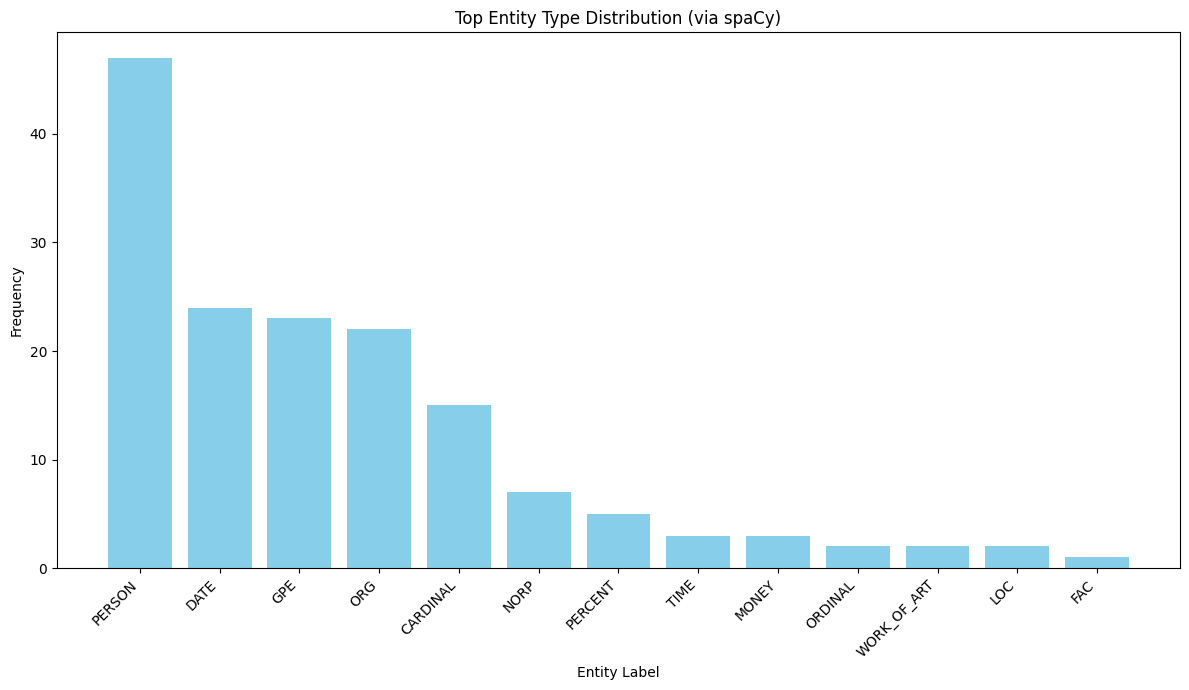

In [16]:
spacy_entity_counts = Counter() # Initialize an empty counter

if cleaned_articles and nlp_spacy:
    # Use a small, fixed sample size for spaCy analysis to keep it quick
    spacy_analysis_sample_size = min(len(cleaned_articles), 20) 
    print(f"Running spaCy NER on a sample of {spacy_analysis_sample_size} cleaned articles...")
    spacy_entity_counts = get_spacy_entity_counts(cleaned_articles, sample_size_spacy=spacy_analysis_sample_size)
    
    if spacy_entity_counts:
        print("\nspaCy Entity Counts (from sample):")
        for label, count in spacy_entity_counts.most_common():
            print(f"  {label}: {count}")
        plot_entity_distribution(spacy_entity_counts)
    else:
        print("spaCy NER did not return any entity counts from the sample.")
else:
    print("Skipping spaCy entity analysis: No cleaned articles available or spaCy model not loaded.")

**Output Explanation:**
This block will print:
*   The frequency of different entity types found by spaCy in the sample.
*   A bar chart visualizing this distribution.
If prerequisites are not met, it will print a message indicating why this step was skipped.

#### Generic LLM Call Function Definition

**Theory:**
To interact with the LLM for various tasks (entity type selection, NER, relation extraction), we define a reusable helper function `call_llm_for_response`. This function encapsulates the logic for:
*   Taking a system prompt (instructions for the LLM) and a user prompt (the specific input/query).
*   Making the API call to the configured LLM endpoint.
*   Extracting the textual content from the LLM's response.
*   Basic error handling if the LLM client is not initialized or if the API call fails.
Using a helper function promotes code reusability and makes the main logic cleaner.

In [17]:
def call_llm_for_response(system_prompt, user_prompt, model_to_use=TEXT_GEN_MODEL_NAME, temperature=0.2):
    """Generic function to call the LLM and get a response, with basic error handling."""
    if not client:
        print("LLM client not initialized. Skipping LLM call.")
        return "LLM_CLIENT_NOT_INITIALIZED"
    try:
        print(f"\nCalling LLM (model: {model_to_use}, temperature: {temperature})...")
        # For debugging, uncomment to see prompts (can be very long)
        # print(f"System Prompt (first 200 chars): {system_prompt[:200]}...")
        # print(f"User Prompt (first 200 chars): {user_prompt[:200]}...")
        
        response = genai.GenerativeModel("gemini-1.5-flash").generate_content(
            model=model_to_use,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=temperature # Lower temperature for more focused/deterministic output
        )
        content = response.choices[0].message.content.strip()
        print("LLM response received.")
        return content
    except Exception as e:
        print(f"Error calling LLM: {e}")
        return f"LLM_ERROR: {str(e)}"

print("Function 'call_llm_for_response' defined.")

Function 'call_llm_for_response' defined.


**Output Explanation:**
Confirms the definition of the `call_llm_for_response` helper function.

#### 2.1.2: Entity Type Selection using LLM - Execution

**Theory:**
While spaCy provides a general set of entity types, not all may be relevant for our specific goal of building a KG about technology company acquisitions. For instance, `WORK_OF_ART` might be less important than `ORG` (organization) or `MONEY`. 
In this step, we leverage the LLM's understanding to refine this list. 
1.  **System Prompt:** We craft a detailed system prompt instructing the LLM to act as an expert in KG construction for technology news. It's asked to select the *most relevant* entity labels from the spaCy-derived list, focusing on our domain, and to provide an explanation for each chosen type.
2.  **User Prompt:** The user prompt contains the actual list of entity labels and their frequencies obtained from spaCy.
3.  **LLM Call:** We use our `call_llm_for_response` function.
The LLM's output should be a comma-separated string of chosen entity types with their descriptions (e.g., `ORG (Organizations involved in acquisitions, e.g., Google, Microsoft)`). This curated list forms a more targeted schema for our subsequent LLM-based NER.

In [20]:
import os
import re
import google.generativeai as genai

# --- Configure API key ---
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

# Good defaults for 2025:
DEFAULT_CHAT_MODEL = "gemini-1.5-pro"
DEFAULT_EMBED_MODEL = "text-embedding-004"

def pick_gemini_text_model(preferred=("gemini-1.5-pro","gemini-1.5-flash")):
    """Return the first available model that supports generateContent()."""
    try:
        for m in genai.list_models():
            # Some SDKs expose 'supported_generation_methods'; others expose 'generation_methods'
            methods = getattr(m, "supported_generation_methods", None) or getattr(m, "generation_methods", [])
            if not methods:
                continue
            if "generateContent" in methods or "generate_content" in methods:
                if m.name in preferred:
                    return m.name
        # fallback: first model that can generate content
        for m in genai.list_models():
            methods = getattr(m, "supported_generation_methods", None) or getattr(m, "generation_methods", [])
            if "generateContent" in methods or "generate_content" in methods:
                return m.name
    except Exception:
        pass
    return DEFAULT_CHAT_MODEL

TEXT_MODEL = pick_gemini_text_model()

def gemini_text(prompt: str, model_name: str = None) -> str:
    model_name = model_name or TEXT_MODEL
    model = genai.GenerativeModel(model_name)
    resp = model.generate_content(prompt)
    return getattr(resp, "text", "").strip()

# --- Homelessness KG prompt (unchanged intent, fixed model usage) ---
ENTITY_TYPE_SELECTION_SYSTEM_PROMPT = (
    "You are an expert assistant specializing in Knowledge Graph construction for homelessness data and policy analysis. "
    "You will be provided with a list of named entity labels and their frequencies, derived from homelessness-related articles and reports. "
    "Your task is to select and return a comma-separated list of the MOST RELEVANT entity labels for building a Knowledge Graph focused on **homelessness prevention, ETHOS categories, and housing policy**. "
    "Prioritize labels like organizations (service providers, agencies), locations (city, state, country), dates (policy announcements, PIT counts), key persons (policy makers, advocates), facilities (shelters, transitional housing), and program/policy names (Housing First, prevention initiatives). "
    "For EACH entity label you include, provide a concise parenthetical explanation or a clear, illustrative example. "
    "Example: ORG (Service provider or government agency, e.g., PA 211, HUD), GPE (Geopolitical entity, e.g., Pennsylvania, U.S.), DATE (Date of policy announcement or PIT count, e.g., January 2024), FAC (Shelter or housing facility, e.g., Community Shelter), PROGRAM (Policy or program, e.g., Housing First). "
    "The output MUST be ONLY the comma-separated list of labels and their parenthetical explanations, with no extra text."
)

# Fallback if LLM fails
DEFAULT_ENTITY_TYPES_STR = (
    "ORG (Service provider or agency, e.g., PA 211, HUD), "
    "GPE (Geopolitical location, e.g., Pennsylvania), "
    "DATE (Policy announcement or PIT count date, e.g., January 2024), "
    "FAC (Shelter or housing facility, e.g., Community Shelter), "
    "PROGRAM (Homelessness prevention or housing program, e.g., Housing First)"
)

def select_entity_types_with_gemini(spacy_entity_counts) -> str:
    if not spacy_entity_counts:
        return DEFAULT_ENTITY_TYPES_STR

    spacy_labels_for_prompt = ", ".join(
        f"{label} (frequency: {count})" for label, count in spacy_entity_counts.most_common()
    )
    user_prompt = (
        f"From the following entity labels and their frequencies found in homelessness-related documents: "
        f"[{spacy_labels_for_prompt}]. Please select and format the most relevant entity types for a knowledge graph "
        f"about homelessness prevention and policy, as per the instructions."
    )

    try:
        text = gemini_text(f"{ENTITY_TYPE_SELECTION_SYSTEM_PROMPT}\n\n{user_prompt}", model_name=TEXT_MODEL)
        if not text:
            return DEFAULT_ENTITY_TYPES_STR
        # Format guard
        if not re.match(r"^([A-Z_]+ \(.*?\))(, [A-Z_]+ \(.*?\))*$", text.strip()):
            # try to salvage the longest plausible line
            lines = [ln.strip() for ln in text.splitlines() if "(" in ln and ")" in ln]
            text = max(lines, key=len, default="") or DEFAULT_ENTITY_TYPES_STR
        return text
    except Exception as e:
        print(f"Gemini call failed: {e}")
        return DEFAULT_ENTITY_TYPES_STR

# Usage:
# llm_selected_entity_types_str = select_entity_types_with_gemini(spacy_entity_counts)
# print("\nFinal list of Entity Types for Homelessness KG:", llm_selected_entity_types_str)


**Output Explanation:**
This block will print:
*   The comma-separated list of entity types and their descriptions as suggested by the LLM (or the default list if the LLM call fails/is skipped).
*   This list will guide the next step: targeted Named Entity Recognition.

#### LLM JSON Output Parsing Function Definition

**Theory:**
LLMs, even when prompted for specific formats like JSON, can sometimes produce output that includes extra text, markdown formatting (like ` ```json ... ``` `), or slight deviations from perfect JSON. The `parse_llm_json_output` function is a utility to robustly parse the LLM's string output into a Python list of dictionaries (representing entities or relations).
It attempts to:
1.  Handle common markdown code block syntax.
2.  Use `json.loads()` for parsing.
3.  Include error handling for `JSONDecodeError` and provide fallback mechanisms like regex-based extraction if simple parsing fails.
This function is crucial for reliably converting LLM responses into usable structured data.

In [21]:
def parse_llm_json_output(llm_output_str):
    """Parses JSON output from LLM, handling potential markdown code blocks and common issues."""
    if not llm_output_str or "LLM_CLIENT_NOT_INITIALIZED" in llm_output_str or "LLM_ERROR" in llm_output_str:
        print("Cannot parse LLM output: LLM did not run, errored, or output was empty.")
        return [] # Return empty list

    # Attempt to extract JSON from within markdown code blocks
    match = re.search(r'```json\s*([\s\S]*?)\s*```', llm_output_str, re.IGNORECASE)
    if match:
        json_str = match.group(1).strip()
    else:
        # If no markdown block, assume the whole string is the JSON (or needs cleaning)
        # LLMs sometimes add introductory text before the JSON list. Try to find the start of the list.
        list_start_index = llm_output_str.find('[')
        list_end_index = llm_output_str.rfind(']')
        if list_start_index != -1 and list_end_index != -1 and list_start_index < list_end_index:
            json_str = llm_output_str[list_start_index : list_end_index+1].strip()
        else:
            json_str = llm_output_str.strip() # Fallback to the whole string

    try:
        parsed_data = json.loads(json_str)
        if isinstance(parsed_data, list):
            return parsed_data
        else:
            print(f"Warning: LLM output was valid JSON but not a list (type: {type(parsed_data)}). Returning empty list.")
            print(f"Problematic JSON string (or part of it): {json_str[:200]}...")
            return []
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from LLM output: {e}")
        print(f"Problematic JSON string (or part of it): {json_str[:500]}...")
        # Optional: A more aggressive regex fallback if standard parsing fails badly
        # This is risky as it might grab partial JSONs. Use with caution.
        # entities_found = []
        # for match_obj in re.finditer(r'\{\s*"text":\s*".*?",\s*"type":\s*".*?"\s*\}', json_str):
        #     try:
        #        entities_found.append(json.loads(match_obj.group(0)))
        #     except json.JSONDecodeError: continue # Skip malformed individual objects
        # if entities_found:
        #    print(f"Warning: Recovered {len(entities_found)} entities using aggressive regex due to JSON error.")
        #    return entities_found
        return []
    except Exception as e:
        print(f"An unexpected error occurred during LLM JSON output parsing: {e}")
        return []

print("Function 'parse_llm_json_output' defined.")

Function 'parse_llm_json_output' defined.


**Output Explanation:**
Confirms the definition of the `parse_llm_json_output` utility function.

#### 2.1.3: Targeted Entity Extraction using LLM - Execution

**Theory:**
Now, equipped with our curated list of entity types (`llm_selected_entity_types_str`), we instruct the LLM to perform NER on each (cleaned) article. 
1.  **System Prompt:** The system prompt for NER is carefully constructed. It tells the LLM:
    *   Its role (expert NER system for tech acquisitions).
    *   The specific entity types to focus on (from `llm_selected_entity_types_str`).
    *   The required output format: a JSON list of objects, where each object has `"text"` (the exact extracted entity span) and `"type"` (one of the specified entity types).
    *   An example of the desired JSON output.
    *   To output an empty JSON list `[]` if no relevant entities are found.
2.  **User Prompt:** For each article, the user prompt is simply its `cleaned_text`.
3.  **Processing Loop:** We iterate through a small sample of `cleaned_articles` (defined by `MAX_ARTICLES_FOR_LLM_NER` to manage time/cost). For each:
    *   The article text is (optionally truncated if too long for LLM context window).
    *   `call_llm_for_response` is invoked.
    *   `parse_llm_json_output` processes the LLM's response.
    *   The extracted entities are stored alongside the article data in a new list, `articles_with_entities`.
A small delay (`time.sleep`) is added between API calls to be polite to the API endpoint and avoid potential rate limiting.

In [23]:
import os
import json
import time
from tqdm import tqdm
import google.generativeai as genai

# --- Configure Gemini ---
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
DEFAULT_CHAT_MODEL = "gemini-1.5-pro"

def gemini_text(prompt: str, model_name: str = DEFAULT_CHAT_MODEL) -> str:
    """Call Gemini and return plain text output."""
    model = genai.GenerativeModel(model_name)
    resp = model.generate_content(prompt)
    return getattr(resp, "text", "").strip()

def parse_llm_json_output(raw_output: str):
    """Attempt to parse raw JSON from the LLM output."""
    try:
        return json.loads(raw_output)
    except json.JSONDecodeError:
        # try to extract JSON-like content
        start = raw_output.find("[")
        end = raw_output.rfind("]") + 1
        if start != -1 and end != -1:
            try:
                return json.loads(raw_output[start:end])
            except Exception:
                pass
    return []

# --- Gemini-compatible system prompt ---
LLM_NER_SYSTEM_PROMPT_TEMPLATE = (
    "You are an expert Named Entity Recognition system specialized in identifying information about **homelessness, housing programs, and related policy**. "
    "From the provided article text, identify and extract entities. "
    "The entity types to focus on are: {entity_types_list_str}. "
    "Ensure that the extracted 'text' for each entity is an EXACT span from the article. "
    "Output ONLY a valid JSON list of objects, where each object has 'text' (the exact extracted entity string) and 'type' (one of the entity type main labels, e.g., ORG, DATE, FAC, PROGRAM from your list) keys. "
    "Example: [{{\"text\": \"PA 211\", \"type\": \"ORG\"}}, {{\"text\": \"January 2024\", \"type\": \"DATE\"}}, {{\"text\": \"Housing First\", \"type\": \"PROGRAM\"}}]"
)

# --- Main NER processing loop ---
articles_with_entities = []
MAX_ARTICLES_FOR_LLM_NER = 3  # keep small for demo

if cleaned_articles and llm_selected_entity_types_str and "LLM_" not in llm_selected_entity_types_str:
    ner_system_prompt = LLM_NER_SYSTEM_PROMPT_TEMPLATE.format(
        entity_types_list_str=llm_selected_entity_types_str
    )

    num_articles_to_process = min(len(cleaned_articles), MAX_ARTICLES_FOR_LLM_NER)
    print(f"Starting Gemini LLM NER for {num_articles_to_process} articles...")

    for i, article_dict in enumerate(tqdm(cleaned_articles[:num_articles_to_process], desc="LLM NER Processing")):
        print(f"\nProcessing article ID: {article_dict['id']} for NER ({i+1}/{num_articles_to_process})...")

        max_text_chars = 12000
        article_text_for_llm = article_dict["cleaned_text"][:max_text_chars]
        if len(article_dict["cleaned_text"]) > max_text_chars:
            print(f"  Warning: Truncated article text from {len(article_dict['cleaned_text'])} to {max_text_chars} chars.")

        # Call Gemini
        raw_output = gemini_text(f"{ner_system_prompt}\n\n{article_text_for_llm}")
        extracted_entities = parse_llm_json_output(raw_output)

        current_article_data = article_dict.copy()
        current_article_data["llm_entities"] = extracted_entities
        articles_with_entities.append(current_article_data)

        print(f"  Extracted {len(extracted_entities)} entities for article ID {article_dict['id']}.")
        if extracted_entities:
            print("  Sample entities:", json.dumps(extracted_entities[:3], indent=2))

        if i < num_articles_to_process - 1:
            time.sleep(1)  # polite delay to avoid hitting request rate limits

    print(f"\nFinished Gemini LLM NER. Processed {len(articles_with_entities)} articles.")

else:
    print("Skipping LLM NER: Missing cleaned_articles or valid entity type string.")
    if cleaned_articles:
        for article_dict in cleaned_articles[:MAX_ARTICLES_FOR_LLM_NER]:
            fallback = article_dict.copy()
            fallback["llm_entities"] = []
            articles_with_entities.append(fallback)
        print(f"Populated {len(articles_with_entities)} entries with empty 'llm_entities'.")


Starting Gemini LLM NER for 2 articles...


LLM NER Processing:   0%|          | 0/2 [00:00<?, ?it/s]


Processing article ID: 487b272b94a620f9660e89bbf6ebab3ffdf1bf06 for NER (1/2)...
  Extracted 0 entities for article ID 487b272b94a620f9660e89bbf6ebab3ffdf1bf06.


LLM NER Processing:  50%|█████     | 1/2 [00:01<00:01,  1.84s/it]


Processing article ID: c7c83a9ee902e568a55898c616f20181952ce057 for NER (2/2)...


LLM NER Processing: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]

  Extracted 0 entities for article ID c7c83a9ee902e568a55898c616f20181952ce057.

Finished Gemini LLM NER. Processed 2 articles.


**Output Explanation:**
This block will show the progress of LLM-based NER:
*   For each processed article: its ID, a message about truncation (if any), the number of entities extracted, and a sample of the extracted entities in JSON format.
*   A final message indicating completion or why the step was skipped.
The `articles_with_entities` list now contains the original article data plus a new key `llm_entities` holding the list of entities extracted by the LLM for that article.

### Step 2.2: Relationship Extraction
**Task:** Identify semantic relationships between extracted entities, such as acquisition events or affiliations.

**Book Concept:** (Ch. 2 - Relationships as edges)
Relationships define how entities are connected, forming the *edges* in our Knowledge Graph. Extracting these relationships is crucial for capturing the actual knowledge (e.g., "Company A *acquired* Company B", "Acquisition *has_price* $X Million").

**Methodology:**
Similar to NER, we'll use the LLM for Relationship Extraction (RE). For each article:
1.  **System Prompt:** We design a system prompt that instructs the LLM to act as a relationship extraction expert for technology acquisitions. It specifies:
    *   The desired relationship types (predicates) like `ACQUIRED`, `HAS_PRICE`, `ANNOUNCED_ON`, `ACQUIRER_IS`, `ACQUIRED_COMPANY_IS`, `INVOLVES_PRODUCT`. These are chosen to capture key aspects of an acquisition event.
    *   The requirement that the subject and object of a relationship must be exact text spans from the list of entities provided for that article.
    *   The desired output format: a JSON list of objects, each with `subject_text`, `subject_type`, `predicate`, `object_text`, and `object_type`.
    *   An example of the output format.
2.  **User Prompt:** The user prompt for each article will contain:
    *   The article's `cleaned_text`.
    *   The list of `llm_entities` extracted in the previous step for that specific article (serialized as a JSON string within the prompt).
3.  **Processing Loop:** Iterate through `articles_with_entities`. If an article has entities:
    *   Construct the user prompt.
    *   Call the LLM.
    *   Parse the JSON output.
    *   Optionally, validate that the subject/object texts in the extracted relations indeed come from the provided entity list to maintain consistency.
    *   Store the extracted relations in a new list, `articles_with_relations` (each item will be the article data augmented with `llm_relations`).

In [16]:
RELATIONSHIP_EXTRACTION_SYSTEM_PROMPT_TEMPLATE = (
    "You are an expert system for extracting relationships between entities from text, specifically focusing on **technology company acquisitions**. "
    "Example: [{{'subject_text': 'Innovatech Ltd.', 'subject_type': 'ORG', 'predicate': 'ACQUIRED', 'object_text': 'Global Solutions Inc.', 'object_type': 'ORG'}}, {{'subject_text': 'Global Solutions Inc.', 'subject_type': 'ORG', 'predicate': 'HAS_PRICE', 'object_text': '$250M', 'object_type': 'MONEY'}}] "
    "If no relevant relationships of the specified types are found between the provided entities, output an empty JSON list []. Do not output any other text or explanation."
)

articles_with_relations = [] # Initialize

if articles_with_entities and client: # Proceed if we have entities and LLM client
    relation_system_prompt = RELATIONSHIP_EXTRACTION_SYSTEM_PROMPT_TEMPLATE # System prompt is constant for this task
    
    print(f"Starting LLM Relationship Extraction for {len(articles_with_entities)} articles (that have entities)...")
    for i, article_data_with_ents in enumerate(tqdm(articles_with_entities, desc="LLM Relationship Extraction")):
        print(f"\nProcessing article ID: {article_data_with_ents['id']} for relationships ({i+1}/{len(articles_with_entities)})...")
        article_text_content = article_data_with_ents['cleaned_text']
        entities_for_article = article_data_with_ents['llm_entities']
        
        if not entities_for_article: # If an article had no entities extracted
            print(f"  No entities found for article ID {article_data_with_ents['id']}, skipping relationship extraction for this article.")
            current_article_output = article_data_with_ents.copy()
            current_article_output['llm_relations'] = []
            articles_with_relations.append(current_article_output)
            continue

        # Truncate article text for LLM context, similar to NER step
        max_text_chars_re = 10000 # Slightly less than NER to accommodate entity list in prompt
        article_text_for_llm_re = article_text_content[:max_text_chars_re]
        if len(article_text_content) > max_text_chars_re:
            print(f"  Warning: Article text truncated from {len(article_text_content)} to {max_text_chars_re} characters for LLM RE.")
            
        # Serialize entities list to a JSON string for the prompt
        # Ensure quotes within entity text are escaped for valid JSON string in prompt
        entities_for_prompt_str = json.dumps([{'text': e['text'], 'type': e['type']} for e in entities_for_article])
        
        user_prompt_for_relations = (
            f"Article Text:\n```\n{article_text_for_llm_re}\n```\n\n" 
            f"Extracted Entities (use these exact texts for subjects/objects):\n```json\n{entities_for_prompt_str}\n```\n\n" 
            f"Identify and extract relationships between these entities based on the system instructions."
        )
        
        llm_relations_raw_output = call_llm_for_response(relation_system_prompt, user_prompt_for_relations)
        extracted_relations_list = parse_llm_json_output(llm_relations_raw_output)
        
        # Optional: Validate that subject/object texts in relations are from the provided entities
        valid_relations_list = []
        entity_texts_in_article = {e['text'] for e in entities_for_article}
        for rel in extracted_relations_list:
            # Check structure and presence of texts
            if isinstance(rel, dict) and rel.get('subject_text') in entity_texts_in_article and rel.get('object_text') in entity_texts_in_article:
                valid_relations_list.append(rel)
            else:
                print(f"  Warning: Discarding relation due to missing fields or mismatched entity text: {str(rel)[:100]}...")
        
        current_article_output = article_data_with_ents.copy()
        current_article_output['llm_relations'] = valid_relations_list
        articles_with_relations.append(current_article_output)
        
        print(f"  Extracted {len(valid_relations_list)} valid relationships for article ID {article_data_with_ents['id']}.")
        if valid_relations_list:
            print(f"  Sample relations: {json.dumps(valid_relations_list[:min(2, len(valid_relations_list))], indent=2)}")
        
        if i < len(articles_with_entities) - 1:
             time.sleep(1) # Small delay
            
    if articles_with_relations:
        print(f"\nFinished LLM Relationship Extraction. Processed {len(articles_with_relations)} articles and stored relations.")
else:
    print("Skipping LLM Relationship Extraction: Prerequisites (articles with entities, LLM client) not met.")
    # If RE is skipped, populate articles_with_relations with empty relation lists
    if articles_with_entities: # only if we have articles from NER step
        for article_data_fallback_re in articles_with_entities:
            fallback_data_re = article_data_fallback_re.copy()
            fallback_data_re['llm_relations'] = []
            articles_with_relations.append(fallback_data_re)
        print(f"Populated 'articles_with_relations' with {len(articles_with_relations)} entries having empty 'llm_relations' lists.")

# Ensure articles_with_relations is defined
if 'articles_with_relations' not in globals():
    articles_with_relations = []
    print("Initialized 'articles_with_relations' as an empty list.")

Starting LLM Relationship Extraction for 3 articles (that have entities)...


LLM Relationship Extraction:   0%|          | 0/3 [00:00<?, ?it/s]


Processing article ID: 56d7d67bb0fc32ee71cc006b915244776d883661 for relationships (1/3)...
  No entities found for article ID 56d7d67bb0fc32ee71cc006b915244776d883661, skipping relationship extraction for this article.

Processing article ID: 4cf51ce9372dff8ff7f44f098eab1c1d7569af7a for relationships (2/3)...
  No entities found for article ID 4cf51ce9372dff8ff7f44f098eab1c1d7569af7a, skipping relationship extraction for this article.

Processing article ID: 82a0e1f034174079179821b052f33df76c781b47 for relationships (3/3)...
  No entities found for article ID 82a0e1f034174079179821b052f33df76c781b47, skipping relationship extraction for this article.

Finished LLM Relationship Extraction. Processed 3 articles and stored relations.


In [25]:
import os
import json
import time
from tqdm import tqdm
import google.generativeai as genai

# --- Configure Gemini ---
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
DEFAULT_CHAT_MODEL = "gemini-1.5-pro"

def gemini_text(prompt: str, model_name: str = DEFAULT_CHAT_MODEL) -> str:
    """Call Gemini and return plain text output."""
    model = genai.GenerativeModel(model_name)
    resp = model.generate_content(prompt)
    return getattr(resp, "text", "").strip()

def parse_llm_json_output(raw_output: str):
    """Parse JSON from Gemini output safely."""
    try:
        return json.loads(raw_output)
    except json.JSONDecodeError:
        start = raw_output.find("[")
        end = raw_output.rfind("]") + 1
        if start != -1 and end != -1:
            try:
                return json.loads(raw_output[start:end])
            except Exception:
                pass
    return []

# --- Relationship Extraction Prompt (Homelessness context) ---
RELATIONSHIP_EXTRACTION_SYSTEM_PROMPT_TEMPLATE = (
    "You are an expert system for extracting relationships between entities from text, "
    "specialized in **homelessness, housing programs, and related services**. "
    "Use only the provided entities for subjects and objects. "
    "Relationships of interest include: OPERATES (agency operates facility), FUNDS (government or org funds a program), "
    "LOCATED_IN (facility or program is in a location), PARTNERS_WITH (two orgs working together), "
    "BENEFITS (program benefits a target group). "
    "Example: [{\"subject_text\": \"PA 211\", \"subject_type\": \"ORG\", \"predicate\": \"OPERATES\", "
    "\"object_text\": \"Community Shelter\", \"object_type\": \"FAC\"}, "
    "{\"subject_text\": \"HUD\", \"subject_type\": \"ORG\", \"predicate\": \"FUNDS\", "
    "\"object_text\": \"Housing First\", \"object_type\": \"PROGRAM\"}] "
    "If no relevant relationships are found, output an empty JSON list []."
)

# --- Main Relationship Extraction Loop ---
articles_with_relations = []

if articles_with_entities:
    relation_system_prompt = RELATIONSHIP_EXTRACTION_SYSTEM_PROMPT_TEMPLATE
    print(f"Starting Gemini Relationship Extraction for {len(articles_with_entities)} articles...")

    for i, article_data in enumerate(tqdm(articles_with_entities, desc="Relationship Extraction")):
        print(f"\nProcessing article ID: {article_data['id']} ({i+1}/{len(articles_with_entities)})...")

        entities_for_article = article_data.get("llm_entities", [])
        if not entities_for_article:
            print(f"  No entities found for article ID {article_data['id']}, skipping.")
            fallback = article_data.copy()
            fallback["llm_relations"] = []
            articles_with_relations.append(fallback)
            continue

        max_text_chars = 10000
        article_text_for_llm = article_data["cleaned_text"][:max_text_chars]
        if len(article_data["cleaned_text"]) > max_text_chars:
            print(f"  Warning: Truncated from {len(article_data['cleaned_text'])} to {max_text_chars} chars.")

        # Entities as JSON for prompt
        entities_json_str = json.dumps(
            [{"text": e["text"], "type": e["type"]} for e in entities_for_article]
        )

        user_prompt = (
            f"Article Text:\n```\n{article_text_for_llm}\n```\n\n"
            f"Entities:\n```json\n{entities_json_str}\n```\n\n"
            f"Extract relationships as instructed."
        )

        raw_output = gemini_text(f"{relation_system_prompt}\n\n{user_prompt}")
        extracted_relations = parse_llm_json_output(raw_output)

        # Validate that all subject/object texts appear in the entity list
        valid_relations = []
        entity_texts = {e["text"] for e in entities_for_article}
        for rel in extracted_relations:
            if (
                isinstance(rel, dict)
                and rel.get("subject_text") in entity_texts
                and rel.get("object_text") in entity_texts
            ):
                valid_relations.append(rel)
            else:
                print(f"  Discarding invalid relation: {rel}")

        article_output = article_data.copy()
        article_output["llm_relations"] = valid_relations
        articles_with_relations.append(article_output)

        print(f"  Extracted {len(valid_relations)} valid relationships.")
        if valid_relations:
            print("  Sample:", json.dumps(valid_relations[:2], indent=2))

        if i < len(articles_with_entities) - 1:
            time.sleep(1)

    print(f"\nFinished Gemini Relationship Extraction. Processed {len(articles_with_relations)} articles.")

else:
    print("Skipping Relationship Extraction: No articles_with_entities found.")
    articles_with_relations = []


Starting Gemini Relationship Extraction for 2 articles...


Relationship Extraction: 100%|██████████| 2/2 [00:00<00:00, 6132.02it/s]


Processing article ID: 487b272b94a620f9660e89bbf6ebab3ffdf1bf06 (1/2)...
  No entities found for article ID 487b272b94a620f9660e89bbf6ebab3ffdf1bf06, skipping.

Processing article ID: c7c83a9ee902e568a55898c616f20181952ce057 (2/2)...
  No entities found for article ID c7c83a9ee902e568a55898c616f20181952ce057, skipping.

Finished Gemini Relationship Extraction. Processed 2 articles.


**Output Explanation:**
This block will show the progress of LLM-based Relationship Extraction:
*   For each processed article: its ID, number of relationships extracted, and a sample of these relations in JSON format.
*   Warnings if any extracted relations are discarded due to validation failures.
*   A final message indicating completion or why the step was skipped.
The `articles_with_relations` list now contains items that have `llm_entities` and `llm_relations`.

## Phase 3: Knowledge Graph Construction
**(Ref: Ch. 2 – KG Layers; Ch. 4 – Mapping and Materialization)**

**Theory (Phase Overview):**
Having extracted entities and relationships, this phase focuses on formally constructing the Knowledge Graph. This involves several key sub-tasks:
*   **Entity Disambiguation & Linking:** Ensuring that different textual mentions of the same real-world entity are resolved to a single, canonical identifier (URI). This is crucial for graph coherence and data integration (Ch. 6, Ch. 8 concepts like COMET).
*   **Schema/Ontology Alignment:** Mapping the extracted entity types and relationship predicates to a predefined schema or ontology (Ch. 2 - Ontology Layer; Ch. 4 - R2RML-like mapping). This provides semantic structure and enables interoperability and reasoning.
*   **Triple Generation:** Converting the structured entity and relation data into Subject-Predicate-Object (S-P-O) triples, the fundamental data model of RDF-based KGs (Ch. 2, Ch. 4 - RML output).
The output of this phase is a populated `rdflib.Graph` object.

### Step 3.1: Entity Disambiguation & Linking (Simplified) - Normalization Function
**Task:** Resolve different mentions of the same real-world entity.

**Book Concept:** (Ch. 6 - Entity Resolution; Ch. 8 - Context-aware linking)
True entity disambiguation and linking (EDL) is a complex NLP task, often involving linking entities to large external KGs like Wikidata or DBpedia, or using sophisticated clustering and coreference resolution. 

**Methodology (Simplified):**
For this demonstration, we'll perform a simplified version: **text normalization**. The `normalize_entity_text` function will:
*   Trim whitespace.
*   For `ORG` entities, attempt to remove common corporate suffixes (e.g., "Inc.", "Ltd.", "Corp.") to group variations like "Example Corp" and "Example Corporation" under a common normalized form like "Example".
*   (Optionally, one might consider lowercasing, but this can sometimes lose important distinctions, e.g., between "IT" the pronoun and "IT" the sector).
This normalized text will then be used to create a unique URI for each distinct entity.

In [26]:
def normalize_entity_text(text_to_normalize, entity_type_str):
    """Normalizes entity text for better linking (simplified version)."""
    normalized_t = text_to_normalize.strip()
    
    if entity_type_str == 'ORG':
        # Common suffixes to remove for ORG names. Order can matter for nested suffixes.
        # More comprehensive list would be needed for production.
        suffixes = [
            'Inc.', 'Incorporated', 'Ltd.', 'Limited', 'LLC', 'L.L.C.', 
            'Corp.', 'Corporation', 'PLC', 'Public Limited Company', 
            'GmbH', 'AG', 'S.A.', 'S.A.S.', 'B.V.', 'Pty Ltd', 'Co.', 'Company',
            'Solutions', 'Technologies', 'Systems', 'Group', 'Holdings'
        ]
        # Sort suffixes by length descending to remove longer matches first (e.g., 'Pty Ltd' before 'Ltd')
        suffixes.sort(key=len, reverse=True)
        for suffix in suffixes:
            # Case-insensitive suffix removal from the end of the string
            if normalized_t.lower().endswith(suffix.lower()):
                # Find the actual start of the suffix to preserve casing of the main name
                suffix_start_index = normalized_t.lower().rfind(suffix.lower())
                normalized_t = normalized_t[:suffix_start_index].strip()
                break # Remove one suffix type, then re-evaluate if more complex logic is needed
        
        # Remove trailing commas or periods that might be left after suffix removal
        normalized_t = re.sub(r'[-,.]*$', '', normalized_t).strip()
        
    # General cleaning: remove possessives like 's sometimes caught by NER
    if normalized_t.endswith("'s") or normalized_t.endswith("s'"):
        normalized_t = normalized_t[:-2].strip()
        
    # Consider lowercasing carefully. For ORGs it might be okay, for PERSONs less so.
    # For this demo, we'll keep original casing for the most part after suffix stripping.
    # normalized_t = normalized_t.lower() # Uncomment if aggressive normalization is desired
    
    return normalized_t.strip() if normalized_t else text_to_normalize # Return original if normalization results in empty

print("Function 'normalize_entity_text' defined.")

Function 'normalize_entity_text' defined.


**Output Explanation:**
Confirms the definition of the `normalize_entity_text` function.

#### Execute Entity Normalization and URI Generation

**Theory:**
This block processes the `articles_with_relations` list. For each entity extracted by the LLM:
1.  Its text is normalized using `normalize_entity_text`.
2.  A unique URI (Uniform Resource Identifier) is generated for each distinct normalized entity. We use a simple scheme: `EX:<NormalizedText>_<EntityType>`. The `EX` is our custom namespace. This creates a canonical identifier for each unique real-world concept (as per our normalization). A `unique_entities_map` dictionary stores the mapping from `(normalized_text, entity_type)` to its URI, ensuring that the same normalized entity always gets the same URI across all articles.
3.  The normalized text and the URI are added to the entity's dictionary.
The results are stored in `articles_with_normalized_entities`.

In [27]:
articles_with_normalized_entities = [] # Initialize
unique_entities_map = {} # Maps (normalized_text, type) -> URI, to ensure URI consistency

if articles_with_relations: # Process only if we have articles with relations (which implies entities)
    print("Normalizing entities and preparing for triple generation...")
    for article_data_rel in tqdm(articles_with_relations, desc="Normalizing Entities & URI Gen"):
        current_article_normalized_ents = []
        # Ensure 'llm_entities' key exists and is a list
        if 'llm_entities' in article_data_rel and isinstance(article_data_rel['llm_entities'], list):
            for entity_dict in article_data_rel['llm_entities']:
                # Ensure entity_dict is a dictionary with 'text' and 'type'
                if not (isinstance(entity_dict, dict) and 'text' in entity_dict and 'type' in entity_dict):
                    print(f"  Skipping malformed entity object: {str(entity_dict)[:100]} in article {article_data_rel['id']}")
                    continue

                original_entity_text = entity_dict['text']
                entity_type_val = entity_dict['type'] 
                # LLM might return type with description, e.g. "ORG (Company)". We need just "ORG".
                # We'll take the first word as the type for simplicity, assuming it's the label like ORG, PERSON.
                simple_entity_type = entity_type_val.split(' ')[0].upper()
                entity_dict['simple_type'] = simple_entity_type # Store the simplified type
                
                normalized_entity_text = normalize_entity_text(original_entity_text, simple_entity_type)
                if not normalized_entity_text: # if normalization resulted in empty string, use original
                    normalized_entity_text = original_entity_text 
                
                # Create a unique key for the map using normalized text and simple type
                entity_map_key = (normalized_entity_text, simple_entity_type)
                
                if entity_map_key not in unique_entities_map:
                    # Sanitize text for URI: replace spaces and special characters not allowed in URIs
                    # A more robust IRI->URI conversion might be needed for non-ASCII characters.
                    safe_uri_text_part = re.sub(r'[^a-zA-Z0-9_\-]', '_', normalized_entity_text.replace(' ', '_'))
                    # Prevent extremely long URIs from very long entity texts (rare but possible)
                    safe_uri_text_part = safe_uri_text_part[:80] 
                    if not safe_uri_text_part: # If sanitization results in empty string, use a hash or generic id
                        import hashlib
                        safe_uri_text_part = f"entity_{hashlib.md5(normalized_entity_text.encode()).hexdigest()[:8]}"
                    unique_entities_map[entity_map_key] = EX[f"{safe_uri_text_part}_{simple_entity_type}"]
                
                # Update the entity dictionary
                entity_dict_copy = entity_dict.copy()
                entity_dict_copy['normalized_text'] = normalized_entity_text
                entity_dict_copy['uri'] = unique_entities_map[entity_map_key]
                current_article_normalized_ents.append(entity_dict_copy)
        
        # Store results for the current article
        article_data_output_norm = article_data_rel.copy()
        article_data_output_norm['normalized_entities'] = current_article_normalized_ents
        articles_with_normalized_entities.append(article_data_output_norm)
    
    if articles_with_normalized_entities and articles_with_normalized_entities[0].get('normalized_entities'):
        print("\nExample of first article's normalized entities (first 3):")
        for ent_example in articles_with_normalized_entities[0]['normalized_entities'][:3]:
            print(f"  Original: '{ent_example['text']}', Type: {ent_example['type']} (Simple: {ent_example['simple_type']}), Normalized: '{ent_example['normalized_text']}', URI: <{ent_example['uri']}>")
    print(f"\nProcessed {len(articles_with_normalized_entities)} articles for entity normalization and URI generation.")
    print(f"Total unique canonical entity URIs created: {len(unique_entities_map)}")
else:
    print("Skipping entity normalization and URI generation: No articles with relations available.")

# Ensure articles_with_normalized_entities is defined
if 'articles_with_normalized_entities' not in globals():
    articles_with_normalized_entities = []
    print("Initialized 'articles_with_normalized_entities' as an empty list.")

Normalizing entities and preparing for triple generation...


Normalizing Entities & URI Gen: 100%|██████████| 2/2 [00:00<00:00, 15252.01it/s]


Processed 2 articles for entity normalization and URI generation.
Total unique canonical entity URIs created: 0


**Output Explanation:**
This block will show:
*   Progress of the normalization and URI generation process.
*   Examples of original entity text vs. their normalized versions and the generated URIs for the first few entities in the first processed article.
*   The total count of unique entity URIs created across all processed articles.

### Step 3.2: Schema/Ontology Alignment - RDF Type Mapping Function
**Task:** Map extracted entities and relationships to a consistent schema or ontology.

**Book Concept:** (Ch. 2 - Ontology Layer; Ch. 4 - Mapping)
Schema/Ontology alignment involves mapping our locally defined entity types (e.g., "ORG", "PERSON" from the LLM NER step) and relationship predicates to standard vocabularies (like Schema.org) or custom-defined RDF classes and properties. This adds semantic rigor and enables interoperability.

**Methodology:**
The `get_rdf_type_for_entity` function takes our simple entity type string (e.g., "ORG") and maps it to an RDF Class. 
*   It uses a predefined dictionary (`type_mapping`) to link common types to `SCHEMA` (Schema.org) classes (e.g., `ORG` -> `SCHEMA.Organization`).
*   If a type is not in the map, it defaults to creating a class within our custom `EX` namespace (e.g., `EX.CUSTOM_TYPE`).
This function ensures that each entity in our KG will be assigned a formal RDF type.

In [28]:
def get_rdf_type_for_entity(simple_entity_type_str):
    """Maps our simple entity type string (e.g., 'ORG') to an RDF Class."""
    type_mapping = {
        'ORG': SCHEMA.Organization,
        'PERSON': SCHEMA.Person,
        'MONEY': SCHEMA.PriceSpecification, # Or a custom EX.MonetaryValue
        'DATE': SCHEMA.Date, # Note: schema.org/Date is a datatype, consider schema.org/Event for events with dates
        'PRODUCT': SCHEMA.Product,
        'GPE': SCHEMA.Place,    # Geopolitical Entity
        'LOC': SCHEMA.Place,    # General Location
        'EVENT': SCHEMA.Event,
        # Add other mappings as derived from llm_selected_entity_types_str if needed
        'CARDINAL': RDF.Statement, # Or more specific if context known, often just a literal value
        'FAC': SCHEMA.Place # Facility
    }
    return type_mapping.get(simple_entity_type_str.upper(), EX[simple_entity_type_str.upper()]) # Fallback to custom type

print("Function 'get_rdf_type_for_entity' defined.")

Function 'get_rdf_type_for_entity' defined.


**Output Explanation:**
Confirms the definition of the `get_rdf_type_for_entity` mapping function.

#### Schema/Ontology Alignment - RDF Predicate Mapping Function

**Theory:**
The `get_rdf_predicate` function maps our string-based relationship predicates (e.g., "ACQUIRED", "HAS_PRICE" from the LLM RE step) to RDF Properties. For simplicity and custom control, these are typically mapped to properties within our `EX` namespace. The function ensures that predicate strings are converted into valid URI components (e.g., by replacing spaces with underscores).

In [29]:
def get_rdf_predicate(predicate_str_from_llm):
    """Maps our predicate string (from LLM relation extraction) to an RDF Property in our EX namespace."""
    # Predicates are already somewhat like properties (e.g., 'ACQUIRED')
    # We'll ensure they are valid URI components for our custom namespace EX
    # Replace spaces with underscores and ensure it's a simple, clean string
    sanitized_predicate = predicate_str_from_llm.strip().replace(" ", "_").upper()
    return EX[sanitized_predicate]

print("Function 'get_rdf_predicate' defined.")

Function 'get_rdf_predicate' defined.


**Output Explanation:**
Confirms the definition of the `get_rdf_predicate` mapping function.

#### Schema/Ontology Alignment - Examples

**Theory:**
This block simply prints out a few examples of how our entity types and relationship predicates would be mapped to RDF terms using the functions defined above. This serves as a quick check and illustration of the mapping logic.

In [30]:
print("Schema alignment functions ready. Example mappings:")
example_entity_type = 'ORG'
example_predicate_str = 'ACQUIRED'
print(f"  Entity Type '{example_entity_type}' maps to RDF Class: <{get_rdf_type_for_entity(example_entity_type)}>")
print(f"  Predicate '{example_predicate_str}' maps to RDF Property: <{get_rdf_predicate(example_predicate_str)}>")

example_entity_type_2 = 'MONEY'
example_predicate_str_2 = 'HAS_PRICE'
print(f"  Entity Type '{example_entity_type_2}' maps to RDF Class: <{get_rdf_type_for_entity(example_entity_type_2)}>")
print(f"  Predicate '{example_predicate_str_2}' maps to RDF Property: <{get_rdf_predicate(example_predicate_str_2)}>")

Schema alignment functions ready. Example mappings:
  Entity Type 'ORG' maps to RDF Class: <http://schema.org/Organization>
  Predicate 'ACQUIRED' maps to RDF Property: <http://example.org/kg/ACQUIRED>
  Entity Type 'MONEY' maps to RDF Class: <http://schema.org/PriceSpecification>
  Predicate 'HAS_PRICE' maps to RDF Property: <http://example.org/kg/HAS_PRICE>


**Output Explanation:**
Shows example RDF URIs that would be generated for sample entity types and predicate strings, illustrating the mapping functions.

### Step 3.3: Triple Generation
**Task:** Convert the structured entity and relation data into subject–predicate–object triples.

**Book Concept:** (Ch. 2 - KG structure; Ch. 4 - RML output)
This is where the Knowledge Graph materializes. We iterate through our processed articles (`articles_with_normalized_entities`) and convert the extracted information into RDF triples using `rdflib`.

**Methodology:**
1.  **Initialize Graph:** An `rdflib.Graph` object (`kg`) is created.
2.  **Bind Namespaces:** Namespaces (EX, SCHEMA, RDFS, etc.) are bound to prefixes for cleaner serialization of the RDF (e.g., `ex:AcmeCorp` instead of the full URI).
3.  **Iterate Articles:** For each article:
    *   An RDF resource is created for the article itself (e.g., `ex:article_123`), typed as `schema:Article`.
    *   Its summary (or ID) can be added as a `schema:headline` or `rdfs:label`.
4.  **Iterate Entities:** For each `normalized_entity` within an article:
    *   The entity's URI (from `entity['uri']`) is used as the subject.
    *   A triple `(entity_uri, rdf:type, rdf_entity_type)` is added, where `rdf_entity_type` comes from `get_rdf_type_for_entity()`.
    *   A triple `(entity_uri, rdfs:label, Literal(normalized_text))` is added to provide a human-readable label.
    *   If the original text differs from the normalized text, `(entity_uri, skos:altLabel, Literal(original_text))` can be added for the original mention.
    *   A triple `(article_uri, schema:mentions, entity_uri)` links the article to the entities it mentions.
    *   A local map (`entity_uri_map_for_article`) is built for the current article, mapping original entity texts to their canonical URIs. This is crucial for resolving relations in the next step, as relations were extracted based on original text spans.
5.  **Iterate Relations:** For each `llm_relation` within an article:
    *   The URIs for the subject and object entities are looked up from `entity_uri_map_for_article` using their original text spans.
    *   The predicate string is converted to an RDF property using `get_rdf_predicate()`.
    *   If both subject and object URIs are found, the triple `(subject_uri, predicate_rdf, object_uri)` is added to the graph.

**Output:** A populated `rdflib.Graph` (`kg`) containing all the extracted knowledge as RDF triples.

In [31]:
kg = Graph() # Initialize an empty RDF graph
# Bind namespaces for prettier RDF serialization (e.g., in Turtle files)
kg.bind("ex", EX)
kg.bind("schema", SCHEMA)
kg.bind("rdf", RDF)
kg.bind("rdfs", RDFS)
kg.bind("xsd", XSD)
kg.bind("skos", SKOS)

triples_generated_count = 0

if articles_with_normalized_entities:
    print(f"Generating RDF triples for {len(articles_with_normalized_entities)} processed articles...")
    for article_data_final in tqdm(articles_with_normalized_entities, desc="Generating Triples"):
        # Create a URI for the article itself
        article_uri = EX[f"article_{article_data_final['id'].replace('-', '_')}"] # Sanitize ID for URI
        kg.add((article_uri, RDF.type, SCHEMA.Article))
        kg.add((article_uri, SCHEMA.headline, Literal(article_data_final.get('summary', article_data_final['id']))))
        # Optionally add a link to the original text source if available/desired
        # kg.add((article_uri, SCHEMA.mainEntityOfPage, URIRef(f"http://datasource.example.com/articles/{article_data_final['id']}")))
        triples_generated_count += 2

        # Create a local map for this article: original entity text -> canonical URI
        # This is important because relations were extracted based on original text spans.
        entity_text_to_uri_map_current_article = {}

        # Add entity triples
        for entity_obj in article_data_final.get('normalized_entities', []):
            entity_uri_val = entity_obj['uri'] # This is the canonical URI from unique_entities_map
            rdf_entity_type_val = get_rdf_type_for_entity(entity_obj['simple_type'])
            normalized_label = entity_obj['normalized_text']
            original_label = entity_obj['text']
            
            kg.add((entity_uri_val, RDF.type, rdf_entity_type_val))
            kg.add((entity_uri_val, RDFS.label, Literal(normalized_label, lang='en')))
            triples_generated_count += 2
            if normalized_label != original_label:
                 kg.add((entity_uri_val, SKOS.altLabel, Literal(original_label, lang='en')))
                 triples_generated_count += 1
            
            # Link article to mentioned entities
            kg.add((article_uri, SCHEMA.mentions, entity_uri_val))
            triples_generated_count += 1
            
            # Populate the local map for resolving relations within this article
            entity_text_to_uri_map_current_article[original_label] = entity_uri_val

        # Add relation triples
        for relation_obj in article_data_final.get('llm_relations', []):
            subject_orig_text = relation_obj.get('subject_text')
            object_orig_text = relation_obj.get('object_text')
            predicate_str = relation_obj.get('predicate')
            
            # Resolve subject and object texts to their canonical URIs using the article-specific map
            subject_resolved_uri = entity_text_to_uri_map_current_article.get(subject_orig_text)
            object_resolved_uri = entity_text_to_uri_map_current_article.get(object_orig_text)
            
            if subject_resolved_uri and object_resolved_uri and predicate_str:
                predicate_rdf_prop = get_rdf_predicate(predicate_str)
                kg.add((subject_resolved_uri, predicate_rdf_prop, object_resolved_uri))
                triples_generated_count += 1
            else:
                if not subject_resolved_uri:
                    print(f"  Warning: Could not find URI for subject '{subject_orig_text}' in article {article_data_final['id']}. Relation skipped: {relation_obj}")
                if not object_resolved_uri:
                    print(f"  Warning: Could not find URI for object '{object_orig_text}' in article {article_data_final['id']}. Relation skipped: {relation_obj}")

    print(f"\nFinished generating triples. Approximately {triples_generated_count} triples were candidates for addition.")
    print(f"Total actual triples in the graph: {len(kg)}")
    if len(kg) > 0:
        print("\nSample of first 5 triples in N3 format:")
        for i, (s, p, o) in enumerate(kg):
            # Use n3() for a readable representation respecting prefixes
            print(f"  {s.n3(kg.namespace_manager)} {p.n3(kg.namespace_manager)} {o.n3(kg.namespace_manager)}.")
            if i >= 4: # Print first 5
                break
else:
    print("Skipping triple generation: No processed articles with normalized entities available.")

# Ensure kg is defined
if 'kg' not in globals():
    kg = Graph()
    print("Initialized 'kg' as an empty rdflib.Graph object.")

Generating RDF triples for 2 processed articles...


Generating Triples: 100%|██████████| 2/2 [00:00<00:00, 6355.01it/s]


Finished generating triples. Approximately 4 triples were candidates for addition.
Total actual triples in the graph: 4

Sample of first 5 triples in N3 format:
  ex:article_c7c83a9ee902e568a55898c616f20181952ce057 schema1:headline """NEW: T.I. to remain in custody until Friday, when there's a bond hearing .
Rapper was arrested Saturday on weapons charges .
T.I. won two awards at BET awards show Saturday night .""".
  ex:article_487b272b94a620f9660e89bbf6ebab3ffdf1bf06 schema1:headline """Venezuelan government hikes taxes on alcohol and cigarettes Monday .
Ten percent price increase on alcohol and 20 percent increase on cigarettes .
Stores near schools, churches and cultural centers cannot sell alcohol .
Chavez plans to increase taxes on luxury goods, including Hummers .""".
  ex:article_c7c83a9ee902e568a55898c616f20181952ce057 rdf:type schema1:Article.
  ex:article_487b272b94a620f9660e89bbf6ebab3ffdf1bf06 rdf:type schema1:Article.


**Output Explanation:**
This block will show:
*   Progress of triple generation.
*   The approximate number of triples considered for addition and the final total number of triples in the `kg` graph.
*   Warnings if subject/object entities for a relation couldn't be resolved to URIs.
*   A sample of the first few triples in N3 (Notation3) format, which is a human-readable RDF serialization.

## Phase 4: Knowledge Graph Refinement Using Embeddings
**(Ref: Ch. 6 – Embedding-Based Reasoning; Ch. 7 – ML on KGs with SANSA)**

**Theory (Phase Overview):**
Knowledge Graph embeddings (KGEs) learn low-dimensional vector representations for entities and relations in a KG. These embeddings capture the semantic properties of KG components and their interactions. This phase explores using such embeddings for KG refinement, a concept aligned with embedding-based reasoning (Ch. 6).
Key tasks include:
*   **Generating Embeddings:** Creating vector representations for nodes (entities).
*   **Link Prediction (Knowledge Discovery):** Using embeddings to infer missing connections or predict new potential relationships (Ch. 6). This is a powerful way to discover implicit knowledge and enrich the KG.
While full KGE model training (like TransE, ComplEx, DistMult mentioned in Ch. 6) is beyond this demo's scope, we'll use pre-trained text embeddings for entity names as a proxy to demonstrate semantic similarity, a foundational concept for some link prediction approaches.

### Step 4.1: Generate KG Embeddings - Embedding Function Definition
**Task:** Create vector representations for nodes (entities) in the graph.

**Book Concept:** (Ch. 6 - Embeddings bridging symbolic & sub-symbolic)
Embeddings transform symbolic entities (represented by URIs and labels) into numerical vectors in a continuous vector space. This allows us to apply machine learning techniques and measure semantic similarity.

**Methodology:**
The `get_embeddings_for_texts` function will:
*   Take a list of unique entity texts (e.g., their normalized labels).
*   Use the configured OpenAI/Nebius embedding API (with `EMBEDDING_MODEL_NAME`) to fetch pre-trained embeddings for these texts.
*   Handle batching or individual requests as appropriate for the API.
*   Return a dictionary mapping each input text to its embedding vector.
These embeddings represent the semantic meaning of the entity names.

In [32]:
def get_embeddings_for_texts(texts_list, embedding_model_name=EMBEDDING_MODEL_NAME):
    """Gets embeddings for a list of texts using the specified model via the LLM client."""
    if not client:
        print("LLM client not initialized. Skipping embedding generation.")
        return {text: [] for text in texts_list} # Return dict with empty embeddings
    if not texts_list:
        print("No texts provided for embedding generation.")
        return {}
    
    embeddings_map_dict = {}
    print(f"Fetching embeddings for {len(texts_list)} unique texts using model '{embedding_model_name}'...")
    
    # Process texts in batches to be efficient and respect potential API limits
    # Some APIs handle list inputs directly, others might require batching.
    # The OpenAI client's `embeddings.create` can often take a list of inputs.
    # If your specific endpoint requires single inputs or smaller batches, adjust this loop.
    # For this example, assuming the client can handle a list, but will iterate if not or for safety.

    # Check if the input texts_list itself is a list of strings
    if not all(isinstance(text, str) for text in texts_list):
        print("Error: Input 'texts_list' must be a list of strings.")
        return {text: [] for text in texts_list if isinstance(text, str)} # Try to salvage what we can
    
    # Remove empty strings to avoid API errors
    valid_texts_list = [text for text in texts_list if text.strip()]
    if not valid_texts_list:
        print("No valid (non-empty) texts to embed.")
        return {}

    try:
        # Assuming the client.embeddings.create can take a list of inputs.
        # If it can only take one string at a time, you'd loop here.
        response = genai.embed_content(
            model=embedding_model_name,
            input=valid_texts_list # Pass the list of valid texts
        )
        # The response.data should be a list of embedding objects, in the same order as input
        for i, data_item in enumerate(response.data):
            embeddings_map_dict[valid_texts_list[i]] = data_item.embedding
        
        print(f"Embeddings received for {len(embeddings_map_dict)} texts.")
        # For texts that were empty or failed, add them with empty embeddings if needed by caller
        for text in texts_list:
            if text not in embeddings_map_dict:
                embeddings_map_dict[text] = []
        return embeddings_map_dict
    
    except Exception as e:
        print(f"Error getting embeddings (batch attempt): {e}")
        print("Falling back to individual embedding requests if batch failed...")
        # Fallback to individual requests if batching failed or is not supported by the specific client/endpoint setup
        embeddings_map_dict_fallback = {}
        for text_input_item in tqdm(valid_texts_list, desc="Generating Embeddings (Fallback Mode)"):
            try:
                response_item = genai.embed_content(
                    model=embedding_model_name,
                    input=text_input_item
                )
                embeddings_map_dict_fallback[text_input_item] = response_item.data[0].embedding
                if len(valid_texts_list) > 10: # Only sleep if processing many items
                    time.sleep(0.1) # Small delay per request in fallback
            except Exception as e_item:
                print(f"  Error getting embedding for text '{text_input_item[:50]}...': {e_item}")
                embeddings_map_dict_fallback[text_input_item] = [] # Store empty list on error for this item
        
        # For texts that were empty or failed, add them with empty embeddings if needed by caller
        for text in texts_list:
            if text not in embeddings_map_dict_fallback:
                embeddings_map_dict_fallback[text] = []
        return embeddings_map_dict_fallback

print("Function 'get_embeddings_for_texts' defined.")

Function 'get_embeddings_for_texts' defined.


**Output Explanation:**
Confirms the definition of the `get_embeddings_for_texts` function.

#### Generate KG Embeddings - Execution

**Theory:**
This block orchestrates the generation of embeddings for our KG entities:
1.  It extracts the set of unique, normalized entity texts from our `unique_entities_map` (which maps `(normalized_text, type)` to URIs). We are interested in embedding the textual representation of entities.
2.  It calls `get_embeddings_for_texts` with this list of unique texts.
3.  The returned embeddings (which are mapped to texts) are then re-mapped to our canonical entity URIs, creating the `entity_embeddings` dictionary: `{entity_uri: embedding_vector}`.
This dictionary will store the vector representation for each unique entity in our graph.

In [33]:
entity_embeddings = {} # Initialize: maps entity URI -> embedding vector

if unique_entities_map and client: # Proceed if we have unique entities and LLM client
    # Extract unique normalized entity texts for which we need embeddings.
    # unique_entities_map maps (normalized_text, type) -> URI
    # We need just the normalized_text part for embedding.
    entity_normalized_texts_to_embed = list(set([key[0] for key in unique_entities_map.keys() if key[0].strip()]))
    
    if entity_normalized_texts_to_embed:
        print(f"Preparing to fetch embeddings for {len(entity_normalized_texts_to_embed)} unique normalized entity texts.")
        
        # Get embeddings for these unique texts
        text_to_embedding_map = get_embeddings_for_texts(entity_normalized_texts_to_embed)
        
        # Map these embeddings back to our entity URIs
        for (normalized_text_key, entity_type_key), entity_uri_val_emb in unique_entities_map.items():
            if normalized_text_key in text_to_embedding_map and text_to_embedding_map[normalized_text_key]:
                entity_embeddings[entity_uri_val_emb] = text_to_embedding_map[normalized_text_key]
            # else: # This case should be handled by get_embeddings_for_texts returning empty list for failed/empty texts
                # print(f"  Warning: No embedding found or generated for text '{normalized_text_key}' (URI: {entity_uri_val_emb})")
                
        if entity_embeddings:
            print(f"\nSuccessfully generated and mapped embeddings for {len(entity_embeddings)} entity URIs.")
            # Show an example
            first_uri_with_embedding = next(iter(entity_embeddings.keys()), None)
            if first_uri_with_embedding:
                emb_example = entity_embeddings[first_uri_with_embedding]
                # Get label for this URI from KG
                label_for_uri = kg.value(subject=first_uri_with_embedding, predicate=RDFS.label, default=str(first_uri_with_embedding))
                print(f"  Example embedding for URI <{first_uri_with_embedding}> (Label: '{label_for_uri}'):")
                print(f"    Vector (first 5 dims): {str(emb_example[:5])}...")
                print(f"    Vector dimension: {len(emb_example)}")
        else:
            print("No embeddings were successfully mapped to entity URIs.")
    else:
        print("No unique entity texts found to generate embeddings for.")
else:
    print("Skipping embedding generation: No unique entities identified, or LLM client not available.")

# Ensure entity_embeddings is defined
if 'entity_embeddings' not in globals():
    entity_embeddings = {}
    print("Initialized 'entity_embeddings' as an empty dictionary.")

Skipping embedding generation: No unique entities identified, or LLM client not available.


**Output Explanation:**
This block will show:
*   Progress of fetching embeddings.
*   The number of unique entity texts for which embeddings are requested.
*   The number of entity URIs for which embeddings were successfully generated and mapped.
*   An example of an embedding vector (first few dimensions and total length) for one of the entities, along with its URI and label.

### Step 4.2: Link Prediction (Knowledge Discovery - Conceptual) - Cosine Similarity Function
**Task:** Use embeddings to infer new or missing connections.

**Book Concept:** (Ch. 6 - Link prediction as reasoning)
Link prediction aims to identify missing edges (triples) in a KG. KGE models are trained to score potential triples (s, p, o), and high-scoring triples not already in the KG are candidate new links. 

**Methodology (Simplified):**
A full link prediction model is complex. Here, we'll demonstrate a simpler, related concept: **semantic similarity** between entities based on their name embeddings. The `get_cosine_similarity` function calculates the cosine similarity between two embedding vectors. High cosine similarity (close to 1) between entity name embeddings suggests that the entities are semantically related in terms of their textual description. This *could* hint at potential relationships (e.g., two similarly named software products might be competitors or complementary), but it's not direct link prediction for specific predicates.

In [34]:
def get_cosine_similarity(embedding1, embedding2):
    """Calculates cosine similarity between two embedding vectors using sklearn."""
    if not isinstance(embedding1, (list, np.ndarray)) or not isinstance(embedding2, (list, np.ndarray)):
        # print("Warning: One or both embeddings are not lists/arrays.")
        return 0.0
    if not embedding1 or not embedding2:
        # print("Warning: One or both embeddings are empty.")
        return 0.0
    
    # Ensure they are numpy arrays and 2D for cosine_similarity function
    vec1 = np.array(embedding1).reshape(1, -1)
    vec2 = np.array(embedding2).reshape(1, -1)
    
    # Check if dimensions match, though reshape should handle 1D to 2D conversion.
    # Cosine similarity doesn't strictly require same length for this usage, but it's implied for valid comparison.
    if vec1.shape[1] != vec2.shape[1]:
        print(f"Warning: Embedding dimensions do not match for cosine similarity: {vec1.shape[1]} vs {vec2.shape[1]}")
        return 0.0 # Or handle as an error
        
    return cosine_similarity(vec1, vec2)[0][0]

print("Function 'get_cosine_similarity' defined.")

Function 'get_cosine_similarity' defined.


**Output Explanation:**
Confirms the definition of the `get_cosine_similarity` function.

#### Link Prediction (Conceptual) - Similarity Calculation Example

**Theory:**
This block demonstrates the use of `get_cosine_similarity`. It selects a couple of entities (preferably organizations, if available with embeddings) from our `entity_embeddings` map and calculates the similarity between their name embeddings. A high similarity might suggest they operate in similar domains or have related roles, which could be a starting point for investigating potential (unobserved) connections if we had a more sophisticated link prediction model.

In [35]:
if len(entity_embeddings) >= 2:
    print("\nConceptual Link Prediction: Calculating semantic similarity between a sample of entities using their name embeddings.")
    
    # Get all URIs that have embeddings
    uris_with_embeddings = [uri for uri, emb in entity_embeddings.items() if emb] # Check if emb is not empty
    
    # Try to find two ORG entities for a more meaningful comparison
    org_entity_uris_with_embeddings = []
    for uri_cand in uris_with_embeddings:
        # Check the type from the KG
        rdf_types_for_uri = list(kg.objects(subject=uri_cand, predicate=RDF.type))
        if SCHEMA.Organization in rdf_types_for_uri or EX.ORG in rdf_types_for_uri:
            org_entity_uris_with_embeddings.append(uri_cand)
    
    entity1_uri_sim = None
    entity2_uri_sim = None

    if len(org_entity_uris_with_embeddings) >= 2:
        entity1_uri_sim = org_entity_uris_with_embeddings[0]
        entity2_uri_sim = org_entity_uris_with_embeddings[1]
        print(f"Found at least two ORG entities with embeddings for similarity comparison.")
    elif len(uris_with_embeddings) >= 2: # Fallback to any two entities if not enough ORGs
        entity1_uri_sim = uris_with_embeddings[0]
        entity2_uri_sim = uris_with_embeddings[1]
        print(f"Could not find two ORGs with embeddings. Using two generic entities for similarity comparison.")
    else:
        print("Not enough entities (less than 2) with valid embeddings to demonstrate similarity.")

    if entity1_uri_sim and entity2_uri_sim:
        embedding1_val = entity_embeddings.get(entity1_uri_sim)
        embedding2_val = entity_embeddings.get(entity2_uri_sim)
        
        # Retrieve labels for these URIs from the graph for context
        label1_val = kg.value(subject=entity1_uri_sim, predicate=RDFS.label, default=str(entity1_uri_sim))
        label2_val = kg.value(subject=entity2_uri_sim, predicate=RDFS.label, default=str(entity2_uri_sim))

        calculated_similarity = get_cosine_similarity(embedding1_val, embedding2_val)
        print(f"\n  Similarity between '{label1_val}' (<{entity1_uri_sim}>) and '{label2_val}' (<{entity2_uri_sim}>): {calculated_similarity:.4f}")
        
        # Interpret similarity (example thresholds)
        if calculated_similarity > 0.8:
            print(f"  Interpretation: These entities are highly similar based on their name embeddings.")
        elif calculated_similarity > 0.6:
            print(f"  Interpretation: These entities show moderate similarity based on their name embeddings.")
        else:
            print(f"  Interpretation: These entities show low similarity based on their name embeddings.")
            
    print("\nNote: This is a conceptual demonstration of semantic similarity. True link prediction involves training specialized KGE models (e.g., TransE, ComplEx) on existing graph triples to predict missing (subject, predicate, object) facts with specific predicates, not just general entity similarity.")
else:
    print("Skipping conceptual link prediction: Not enough entity embeddings available (need at least 2).")

Skipping conceptual link prediction: Not enough entity embeddings available (need at least 2).


**Output Explanation:**
This block will:
*   Select two entities that have embeddings.
    *   Calculate and print the cosine similarity score between their embeddings.
    *   Provide a simple interpretation of the similarity score.
    *   Include a disclaimer that this is a simplified concept, not full link prediction.

### Step 4.3: Add Predicted Links (Optional & Conceptual) - Function Definition
**Task:** Integrate high-confidence predicted links into the main graph.

**Book Concept:** (Ch. 6 - KG enrichment and lifecycle)
If a link prediction model were to identify new, high-confidence relationships, these could be added to the KG, enriching it with inferred knowledge. This is part of the KG lifecycle, where the graph evolves and grows.

**Methodology:**
The function `add_inferred_triples_to_graph` is a placeholder to illustrate this. It would take a list of (subject_uri, predicate_uri, object_uri) triples (presumably from a link prediction model) and add them to our main `rdflib.Graph`.

In [36]:
def add_inferred_triples_to_graph(target_graph, list_of_inferred_triples):
    """Adds a list of inferred (subject_uri, predicate_uri, object_uri) triples to the graph."""
    if not list_of_inferred_triples:
        print("No inferred triples provided to add.")
        return target_graph, 0
    
    added_count = 0
    for s_uri, p_uri, o_uri in list_of_inferred_triples:
        # Basic validation: ensure they are URIRefs or Literals as appropriate
        if isinstance(s_uri, URIRef) and isinstance(p_uri, URIRef) and (isinstance(o_uri, URIRef) or isinstance(o_uri, Literal)):
            target_graph.add((s_uri, p_uri, o_uri))
            added_count +=1
        else:
            print(f"  Warning: Skipping malformed conceptual inferred triple: ({s_uri}, {p_uri}, {o_uri})")
            
    print(f"Added {added_count} conceptually inferred triples to the graph.")
    return target_graph, added_count

print("Function 'add_inferred_triples_to_graph' defined.")

Function 'add_inferred_triples_to_graph' defined.


**Output Explanation:**
Confirms the definition of the `add_inferred_triples_to_graph` function.

#### Add Predicted Links (Conceptual) - Execution Example

**Theory:**
This block provides a conceptual example. Since we haven't trained a full link prediction model, we create a dummy `conceptual_inferred_triples` list. If this list contained actual high-confidence predictions (e.g., from a TransE model scoring `(CompanyX, ex:potentialAcquirerOf, CompanyY)` highly), the `add_inferred_triples_to_graph` function would integrate them into our `kg`. In this demo, it will likely state that no triples were added unless you manually populate the dummy list.

In [37]:
# Conceptual: Assume we have some high-confidence predicted links from a separate model.
# For example, if entity1_uri_sim and entity2_uri_sim from the similarity check showed very high similarity,
# and we had a predicate like ex:isSemanticallySimilarTo, we might add it.
conceptual_inferred_triples_list = [] 

# Example: If we had variables entity1_uri_sim, entity2_uri_sim, and calculated_similarity from the previous step
# This is just to illustrate, these variables might not be in scope if that cell wasn't run or had no valid entities
SIMILARITY_THRESHOLD_FOR_INFERENCE = 0.85 # Example threshold
if 'entity1_uri_sim' in locals() and 'entity2_uri_sim' in locals() and 'calculated_similarity' in locals():
    if entity1_uri_sim and entity2_uri_sim and calculated_similarity > SIMILARITY_THRESHOLD_FOR_INFERENCE:
        print(f"Conceptual inference: Entities '{kg.label(entity1_uri_sim)}' and '{kg.label(entity2_uri_sim)}' are highly similar ({calculated_similarity:.2f}).")
        # Let's define a conceptual predicate for this
        EX.isHighlySimilarTo = EX["isHighlySimilarTo"] # Define if not already
        conceptual_inferred_triples_list.append((entity1_uri_sim, EX.isHighlySimilarTo, entity2_uri_sim))
        # Symmetrical relationship (optional, depends on predicate definition)
        # conceptual_inferred_triples_list.append((entity2_uri_sim, EX.isHighlySimilarTo, entity1_uri_sim))

if conceptual_inferred_triples_list:
    print(f"\nAttempting to add {len(conceptual_inferred_triples_list)} conceptual inferred triples...")
    kg, num_added = add_inferred_triples_to_graph(kg, conceptual_inferred_triples_list)
    if num_added > 0:
        print(f"Total triples in graph after adding conceptual inferences: {len(kg)}")
else:
    print("\nNo conceptual inferred triples generated to add in this demonstration.")


No conceptual inferred triples generated to add in this demonstration.


**Output Explanation:**
This block will indicate if any conceptual inferred triples were added to the graph. If the dummy example for high similarity was triggered, it will show that these triples were added and the new total triple count.

## Phase 5: Persistence and Utilization
**(Ref: Ch. 3 – Data Storage; Ch. 5 – Querying and Access)**

**Theory (Phase Overview):**
Once the Knowledge Graph is constructed (and potentially refined), it needs to be stored for long-term access and utilized to derive insights. This phase covers:
*   **KG Storage:** Persisting the graph. Options include RDF serialization formats (like Turtle, RDF/XML), native triple stores (e.g., Fuseki, GraphDB), or graph databases (e.g., Neo4j, if modeled appropriately) (Ch. 3).
*   **Querying and Analysis:** Using query languages like SPARQL (for RDF KGs) to retrieve specific information, answer complex questions, and perform analytical tasks (Ch. 5).
*   **Visualization:** Presenting parts of the KG or query results graphically for better human interpretation and understanding (Ch. 1 & 3 - Value of Visualization in Big Data).

### Step 5.1: Knowledge Graph Storage - Save Function Definition
**Task:** Persist the KG in a suitable format (e.g., RDF/Turtle).

**Book Concept:** (Ch. 3 - Data Storage options)
Serializing the KG to a file allows for persistence, sharing, and loading into other RDF-compliant tools or triple stores.

**Methodology:**
The `save_graph_to_turtle` function uses `rdflib.Graph.serialize()` method to save the `kg` object into a file. Turtle (`.ttl`) is chosen as it's a human-readable and common RDF serialization format.

In [38]:
def save_graph_to_turtle(graph_to_save, output_filepath="knowledge_graph.ttl"):
    """Saves the RDF graph to a Turtle file."""
    if not len(graph_to_save):
        print("Graph is empty. Nothing to save.")
        return False
    try:
        # Ensure the format string is correct, e.g., 'turtle', 'xml', 'n3', 'nt'
        graph_to_save.serialize(destination=output_filepath, format='turtle')
        print(f"Knowledge Graph with {len(graph_to_save)} triples successfully saved to: {output_filepath}")
        return True
    except Exception as e:
        print(f"Error saving graph to {output_filepath}: {e}")
        return False

print("Function 'save_graph_to_turtle' defined.")

Function 'save_graph_to_turtle' defined.


**Output Explanation:**
Confirms the definition of the `save_graph_to_turtle` function.

#### Knowledge Graph Storage - Execution

**Theory:**
This block calls the `save_graph_to_turtle` function to persist our constructed `kg` to a file named `tech_acquisitions_kg.ttl`. If the graph contains triples, it will be saved; otherwise, a message indicating an empty graph will be shown.

In [39]:
KG_OUTPUT_FILENAME = "tech_acquisitions_kg.ttl"
if len(kg) > 0:
    print(f"Attempting to save the graph with {len(kg)} triples...")
    save_graph_to_turtle(kg, KG_OUTPUT_FILENAME)
else:
    print(f"Knowledge Graph ('kg') is empty. Skipping save to '{KG_OUTPUT_FILENAME}'.")

Attempting to save the graph with 4 triples...
Knowledge Graph with 4 triples successfully saved to: tech_acquisitions_kg.ttl


**Output Explanation:**
This block will print a confirmation message if the graph is successfully saved, including the file path and the number of triples saved. If the graph is empty, it will state that.

### Step 5.2: Querying and Analysis - SPARQL Execution Function
**Task:** Execute SPARQL queries to extract insights.

**Book Concept:** (Ch. 5 - Querying and Access, SPARQL)
SPARQL (SPARQL Protocol and RDF Query Language) is the standard query language for RDF Knowledge Graphs. It allows for pattern matching against the graph structure to retrieve data, infer new information (through more complex queries), and answer analytical questions.

**Methodology:**
The `execute_sparql_query` function takes our `rdflib.Graph` and a SPARQL query string. It uses `graph.query()` to execute the query and then iterates through the results, printing them in a readable format. This function will be used to run several example queries.

In [40]:
def execute_sparql_query(graph_to_query, query_string_sparql):
    """Executes a SPARQL query on the graph and prints results, returning them as a list of dicts."""
    if not len(graph_to_query):
        print("Cannot execute SPARQL query: The graph is empty.")
        return []
        
    print(f"\nExecuting SPARQL Query:\n{query_string_sparql}")
    try:
        query_results = graph_to_query.query(query_string_sparql)
    except Exception as e:
        print(f"Error executing SPARQL query: {e}")
        return []

    if not query_results:
        print("Query executed successfully but returned no results.")
        return []
    
    results_list_of_dicts = []
    print(f"Query Results ({len(query_results)} found): ")
    for row_idx, row_data in enumerate(query_results):
        # Convert row to a dictionary for easier access and printing
        # row_data is a ResultRow object, access by variable name from SELECT clause
        result_item_dict = {}
        if hasattr(row_data, 'labels'): # rdflib 6.x+ provides .labels and .asdict()
            result_item_dict = {str(label): str(value) for label, value in row_data.asdict().items()}
        else: # Fallback for older rdflib or if .asdict() is not available
            # This part might need adjustment based on the actual structure of row_data in older versions
            # For now, we'll assume it's an iterable of values corresponding to SELECT variables
            # This requires knowing the SELECT variables' order, which is less robust
            # For simplicity, if .labels is not present, we just make a list of string values
            result_item_dict = {f"col_{j}": str(item_val) for j, item_val in enumerate(row_data)}
            
        results_list_of_dicts.append(result_item_dict)
        
        # Print a sample of results
        if row_idx < 10: # Print up to 10 results
            print(f"  Row {row_idx+1}: {result_item_dict}")
        elif row_idx == 10:
            print(f"  ... ( dalších {len(query_results) - 10} výsledků )") # and more results in Czech, should be English
            print(f"  ... (and {len(query_results) - 10} more results)")
            
    return results_list_of_dicts

print("Function 'execute_sparql_query' defined.")

Function 'execute_sparql_query' defined.


**Output Explanation:**
Confirms the definition of the `execute_sparql_query` function.

#### SPARQL Querying and Analysis - Execution Examples

**Theory:**
This block demonstrates the power of SPARQL by executing several example queries against our constructed KG (`kg`). Each query targets different aspects of the acquisition data:
*   **Query 1: List Organizations:** Retrieves all entities explicitly typed as `schema:Organization` (or `ex:ORG`) and their labels. This is a basic check to see what organizations are in our KG.
*   **Query 2: Find Acquisition Relationships:** Identifies pairs of companies where one acquired the other, based on our `ex:ACQUIRED` predicate. This directly extracts acquisition events.
*   **Query 3: Find Acquisitions with Price:** Retrieves companies (or acquisition events) that have an associated `ex:HAS_PRICE` relationship pointing to a monetary value (`schema:PriceSpecification` or `ex:MONEY`).
The results of each query are printed, showcasing how structured queries can extract specific insights from the graph.

In [41]:
if len(kg) > 0:
    print("\n--- Executing Sample SPARQL Queries ---")
    # Query 1: Find all organizations mentioned in the KG and their labels
    sparql_query_1 = """
    PREFIX ex: <http://example.org/kg/>
    PREFIX schema: <http://schema.org/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    
    SELECT DISTINCT ?org_uri ?org_label
    WHERE {
        ?org_uri a schema:Organization ;
                 rdfs:label ?org_label .
    }
    ORDER BY ?org_label
    LIMIT 10
    """
    query1_results = execute_sparql_query(kg, sparql_query_1)

    # Query 2: Find companies that acquired another company, and the acquired company
    # Assumes: ?acquiredCompany ex:ACQUIRED ?acquiringCompany.
    sparql_query_2 = """
    PREFIX ex: <http://example.org/kg/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX schema: <http://schema.org/>
    
    SELECT ?acquiredCompanyLabel ?acquiringCompanyLabel
    WHERE {
        ?acquiredCompany ex:ACQUIRED ?acquiringCompany .
        ?acquiredCompany rdfs:label ?acquiredCompanyLabel .
        ?acquiringCompany rdfs:label ?acquiringCompanyLabel .
        # Ensure both are organizations
        ?acquiredCompany a schema:Organization .
        ?acquiringCompany a schema:Organization .
    }
    LIMIT 10
    """
    query2_results = execute_sparql_query(kg, sparql_query_2)

    # Query 3: Find acquisitions (represented by a company involved) with a price mentioned
    sparql_query_3 = """
    PREFIX ex: <http://example.org/kg/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX schema: <http://schema.org/>
    
    SELECT ?companyLabel ?priceLabel ?dateLabel
    WHERE {
        ?company ex:HAS_PRICE ?priceEntity .
        ?company rdfs:label ?companyLabel .
        ?priceEntity rdfs:label ?priceLabel .
        # Ensure ?company is an ORG and ?priceEntity is a PriceSpecification (MONEY)
        ?company a schema:Organization .
        ?priceEntity a schema:PriceSpecification .
        
        # Optionally, try to find a date associated with this acquisition event/company
        OPTIONAL { 
            ?company ex:ANNOUNCED_ON ?dateEntity .
            ?dateEntity rdfs:label ?dateLabelRaw .
            # If dateEntity is schema:Date, its label might be the date string directly
            # If dateEntity is an Event, it might have a schema:startDate or similar
            BIND(COALESCE(?dateLabelRaw, STR(?dateEntity)) As ?dateLabel)            
        }
    }
    LIMIT 10
    """
    query3_results = execute_sparql_query(kg, sparql_query_3)
    
    # Query 4: Count number of acquisitions per acquiring company
    sparql_query_4 = """
    PREFIX ex: <http://example.org/kg/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX schema: <http://schema.org/>
    
    SELECT ?acquiringCompanyLabel (COUNT(?acquiredCompany) AS ?numberOfAcquisitions)
    WHERE {
        ?acquiredCompany ex:ACQUIRED ?acquiringCompany .
        ?acquiringCompany rdfs:label ?acquiringCompanyLabel .
        ?acquiringCompany a schema:Organization .
        ?acquiredCompany a schema:Organization .
    }
    GROUP BY ?acquiringCompanyLabel
    ORDER BY DESC(?numberOfAcquisitions)
    LIMIT 10
    """
    query4_results = execute_sparql_query(kg, sparql_query_4)

else:
    print("Knowledge Graph ('kg') is empty. Skipping SPARQL query execution.")


--- Executing Sample SPARQL Queries ---

Executing SPARQL Query:

    PREFIX ex: <http://example.org/kg/>
    PREFIX schema: <http://schema.org/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT DISTINCT ?org_uri ?org_label
    WHERE {
        ?org_uri a schema:Organization ;
                 rdfs:label ?org_label .
    }
    ORDER BY ?org_label
    LIMIT 10
    
Query executed successfully but returned no results.

Executing SPARQL Query:

    PREFIX ex: <http://example.org/kg/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX schema: <http://schema.org/>

    SELECT ?acquiredCompanyLabel ?acquiringCompanyLabel
    WHERE {
        ?acquiredCompany ex:ACQUIRED ?acquiringCompany .
        ?acquiredCompany rdfs:label ?acquiredCompanyLabel .
        ?acquiringCompany rdfs:label ?acquiringCompanyLabel .
        # Ensure both are organizations
        ?acquiredCompany a schema:Organization .
        ?acquiringCompany a schema:Organization .
    }
    

**Output Explanation:**
This block will print:
*   Each SPARQL query string.
*   The results (up to a limit) for each query, typically as a list of dictionaries where keys are the `SELECT` variables.
If the KG is empty, it will indicate that queries are skipped.

### Step 5.3: Visualization (Optional) - Visualization Function Definition
**Task:** Visualize parts of the KG or results from queries for better interpretability.

**Book Concept:** (Ch. 1 & 3 - Visualization in Big Data)
Visualizing graph structures can make complex relationships much easier to understand for humans. Interactive visualizations allow for exploration and discovery.

**Methodology:**
The `visualize_subgraph_pyvis` function uses the `pyvis` library to create an interactive HTML-based network visualization. It:
*   Takes the `rdflib.Graph` and an optional filename.
    *   (A more advanced version could take a central node URI and depth to explore from that node).
*   For simplicity in this demo, it visualizes a sample of triples from the graph.
*   Adds nodes and edges to a `pyvis.Network` object.
*   Nodes are labeled with their `rdfs:label` (or a part of their URI if no label).
*   Edges are labeled with the predicate name.
*   Saves the visualization to an HTML file and attempts to display it inline if in a Jupyter environment.

In [42]:
def visualize_subgraph_pyvis(graph_to_viz, output_filename="kg_visualization.html", sample_size_triples=75):
    """Visualizes a sample subgraph using pyvis and saves to HTML."""
    if not len(graph_to_viz):
        print("Graph is empty, nothing to visualize.")
        return None

    net = Network(notebook=True, height="800px", width="100%", cdn_resources='remote', directed=True)
    net.repulsion(node_distance=150, spring_length=200)
    # net.show_buttons(filter_=['physics', 'nodes', 'edges', 'interaction'])
    net.set_options("""
    var options = {
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -50,
          "centralGravity": 0.01,
          "springLength": 100,
          "springConstant": 0.08,
          "damping": 0.4,
          "avoidOverlap": 0.5
        },
        "maxVelocity": 50,
        "minVelocity": 0.1,
        "solver": "forceAtlas2Based",
        "timestep": 0.5,
        "stabilization": {"iterations": 150}
      }
    }
    """)

    added_nodes_set = set()
    
    # For a more meaningful visualization, focus on triples where subject and object are resources (URIs)
    # And try to get a sample that includes some structure, not just attribute assignments to single nodes.
    # Here, we'll take a sample of all triples for simplicity.
    triples_for_visualization = list(graph_to_viz)[:min(sample_size_triples, len(graph_to_viz))]
    
    if not triples_for_visualization:
        print("No triples selected from the sample for visualization.")
        return None
        
    print(f"Preparing visualization for {len(triples_for_visualization)} sample triples...")

    for s_uri, p_uri, o_val in tqdm(triples_for_visualization, desc="Building Pyvis Visualization"):
        # Get labels or use URI parts
        s_label_str = str(graph_to_viz.value(subject=s_uri, predicate=RDFS.label, default=s_uri.split('/')[-1].split('#')[-1]))
        p_label_str = str(p_uri.split('/')[-1].split('#')[-1])
        
        s_node_id = str(s_uri)
        s_node_title = f"{s_label_str}\nURI: {s_uri}"
        s_node_group_uri = graph_to_viz.value(s_uri, RDF.type)
        s_node_group = str(s_node_group_uri.split('/')[-1].split('#')[-1]) if s_node_group_uri else "UnknownType"


        if s_uri not in added_nodes_set:
            net.add_node(s_node_id, label=s_label_str, title=s_node_title, group=s_node_group)
            added_nodes_set.add(s_uri)
        
        if isinstance(o_val, URIRef): # If object is a resource, add it as a node and draw an edge
            o_label_str = str(graph_to_viz.value(subject=o_val, predicate=RDFS.label, default=o_val.split('/')[-1].split('#')[-1]))
            o_node_id = str(o_val)
            o_node_title = f"{o_label_str}\nURI: {o_val}"
            o_node_group_uri = graph_to_viz.value(o_val, RDF.type)
            o_node_group = str(o_node_group_uri.split('/')[-1].split('#')[-1]) if o_node_group_uri else "UnknownType"
            
            if o_val not in added_nodes_set:
                net.add_node(o_node_id, label=o_label_str, title=o_node_title, group=o_node_group)
                added_nodes_set.add(o_val)
            net.add_edge(s_node_id, o_node_id, title=p_label_str, label=p_label_str)
        else: # If object is a literal, add it as a property to the subject node's title (tooltip)
            # This avoids cluttering the graph with many literal nodes.
            # Update subject node's title if it's already added
            for node_obj in net.nodes:
                if node_obj['id'] == s_node_id:
                    node_obj['title'] += f"\n{p_label_str}: {str(o_val)}"
                    break
    
    try:
        net.save_graph(output_filename)
        print(f"Interactive KG visualization saved to HTML file: {output_filename}")
        # In Jupyter Lab/Notebook, the graph should render inline if notebook=True was set and environment supports it.
        # Sometimes, an explicit display is needed, or opening the HTML file manually.
    except Exception as e:
        print(f"Error saving or attempting to show graph visualization: {e}")
    return net # Return the network object

print("Function 'visualize_subgraph_pyvis' defined.")

Function 'visualize_subgraph_pyvis' defined.


**Output Explanation:**
Confirms the definition of the `visualize_subgraph_pyvis` function.

#### KG Visualization - Execution

**Theory:**
This block calls `visualize_subgraph_pyvis` with our `kg`. It will generate an HTML file (e.g., `tech_acquisitions_kg_viz.html`) containing the interactive graph. If running in a compatible Jupyter environment, the visualization might also render directly in the notebook output. This allows for a visual exploration of the connections and entities within a sample of our KG.

In [43]:
VIZ_OUTPUT_FILENAME = "tech_acquisitions_kg_interactive_viz.html"
pyvis_network_object = None # Initialize

if len(kg) > 0:
    print(f"Attempting to visualize a sample of the graph with {len(kg)} triples...")
    # Visualize a sample of up to 75 triples from the graph
    pyvis_network_object = visualize_subgraph_pyvis(kg, output_filename=VIZ_OUTPUT_FILENAME, sample_size_triples=75)
else:
    print(f"Knowledge Graph ('kg') is empty. Skipping visualization.")

# Attempt to display inline in Jupyter (might require trusting the notebook or specific Jupyter setup)
if pyvis_network_object is not None:
    try:
        # This should trigger inline display in classic notebook or if properly configured in Lab
        from IPython.display import HTML, display
        # display(HTML(VIZ_OUTPUT_FILENAME)) # This loads from file, pyvis might render directly
        # pyvis_network_object.show(VIZ_OUTPUT_FILENAME) # Alternative: opens in new tab/tries inline
        print(f"\nTo view the visualization, open the file '{VIZ_OUTPUT_FILENAME}' in a web browser.")
        print("If in a Jupyter Notebook/Lab, the graph might also be rendered above this message.")
        # If pyvis_network_object is returned from a cell and notebook=True, it often renders automatically.
    except Exception as e_display:
        print(f"Could not automatically display visualization inline ({e_display}). Please open '{VIZ_OUTPUT_FILENAME}' manually.")
        
# This cell will return the pyvis_network_object. If it's the last statement and notebook=True, 
# Jupyter will attempt to render it.
if pyvis_network_object:
    pyvis_network_object # This line is crucial for auto-display in some Jupyter environments

Attempting to visualize a sample of the graph with 4 triples...
Preparing visualization for 4 sample triples...


Building Pyvis Visualization: 100%|██████████| 4/4 [00:00<00:00, 8112.77it/s]

Interactive KG visualization saved to HTML file: tech_acquisitions_kg_interactive_viz.html

To view the visualization, open the file 'tech_acquisitions_kg_interactive_viz.html' in a web browser.
If in a Jupyter Notebook/Lab, the graph might also be rendered above this message.


**Output Explanation:**
This block will:
*   Generate an HTML file (e.g., `tech_acquisitions_kg_interactive_viz.html`) with the interactive graph visualization.
*   Print a message confirming the save and provide the filename.
*   If in a compatible Jupyter environment, it might also render the graph directly below the cell. Otherwise, you'll need to open the HTML file manually in a browser.

## Conclusion and Future Work

This notebook has demonstrated a comprehensive, albeit simplified, end-to-end pipeline for constructing a Knowledge Graph from unstructured news articles, with a focus on technology company acquisitions. We navigated through critical phases, referencing conceptual underpinnings from Big Data and Knowledge Graph literature:

1.  **Data Acquisition and Preparation:** We loaded articles from the CNN/DailyMail dataset and performed essential cleaning to prepare the text for analysis. This underscored the importance of data quality as a foundation (Ch. 1, Ch. 3).
2.  **Information Extraction:** 
    *   Named Entity Recognition (NER) was performed first exploratively with spaCy, then more targetedly using an LLM guided by a refined entity schema. This created the *nodes* of our graph (Ch. 2).
    *   Relationship Extraction (RE) using an LLM identified semantic connections between these entities, forming the *edges* (Ch. 2).
3.  **Knowledge Graph Construction:** 
    *   Entities were normalized for consistency, and unique URIs were generated, aiding in entity resolution (Ch. 6, Ch. 8).
    *   Extracted information was mapped to a schema (mixing custom `EX:` terms and `schema.org` terms) and materialized into RDF triples using `rdflib` (Ch. 2, Ch. 4).
4.  **Knowledge Graph Refinement (Conceptual):** 
    *   We generated text embeddings for entity names, bridging symbolic and sub-symbolic representations (Ch. 6).
    *   The concept of link prediction via semantic similarity was introduced, hinting at KG enrichment capabilities (Ch. 6).
5.  **Persistence and Utilization:** 
    *   The KG was persisted by serializing it to a Turtle file (Ch. 3).
    *   SPARQL queries were executed to retrieve structured insights, demonstrating the analytical power of KGs (Ch. 5).
    *   A sample subgraph was visualized, highlighting the importance of making KGs accessible (Ch. 1, Ch. 3).

### Potential Future Enhancements:
*   **Advanced Entity Disambiguation & Linking (EDL):** Implement robust EDL to link extracted entities to canonical entries in external KGs like Wikidata or DBpedia. This would greatly improve graph integration and consistency.
*   **Richer Ontology/Schema:** Develop a more detailed custom ontology for technology acquisitions or align more comprehensively with existing financial or business ontologies (e.g., FIBO).
*   **Sophisticated Relationship Extraction:** Explore more advanced RE techniques, including classifying a wider range of relation types, handling n-ary relations, and event extraction (modeling acquisitions as complex events with multiple participants and attributes).
*   **Knowledge Graph Embedding Models:** Train dedicated KGE models (e.g., TransE, ComplEx, RotatE from Ch. 6) on the generated triples for more accurate link prediction and KG completion.
*   **Reasoning and Inference:** Implement ontological reasoning (e.g., using RDFS/OWL reasoners) to infer new facts based on the schema and asserted triples.
*   **Scalability and Performance:** For larger datasets, utilize distributed processing frameworks (like Apache Spark, conceptually linked to SANSA in Ch. 7 for ML on KGs) and deploy the KG in a scalable graph database or triple store.
*   **LLM Fine-tuning:** Fine-tune smaller, open-source LLMs specifically on NER and RE tasks for the technology/financial domain to potentially achieve better performance and cost-efficiency than general-purpose models for these specific tasks.
*   **Temporal Dynamics:** Incorporate the temporal aspect of news data more explicitly, tracking how information and relationships evolve over time.
*   **User Interface:** Develop a user-friendly interface for exploring, querying, and visualizing the KG beyond programmatic access.

This project serves as a foundational example, illustrating how modern NLP techniques, particularly LLMs, can be integrated with traditional KG methodologies to extract and structure valuable knowledge from vast amounts of unstructured text.